<small>
<pre style=" font-size: smaller;">
                                                (@@@)     (@@@@@)
                                           (@@)     (@@@@@@@)        (@@@@@@@)
                                     (@@@@@@@)   (@@@@@)       (@@@@@@@@@@@)
                                (@@@)     (@@@@@@@)   (@@@@@@)             (@@@)
                           (@@@@@@)    (@@@@@@)                (@)
                       (@@@)  (@@@@)           (@@)
                    (@@)              (@@@)
                   .-.               
                   ] [    .-.      _    .-----.
                 ."   """"   """""" """"| .--`
                (:--:--:--:--:--:--:--:-| [___    .------------------------.
                 |C&O  :  :  :  :  :  : [_9_] |'='|.----------------------.|
                /|.___________________________|___|'--.___.--.___.--.___.-'| 
               / ||_.--.______.--.______.--._ |---\'--\-.-/==\-.-/==\-.-/-'/--
              /__;^=(==)======(==)======(==)=^~^^^ ^^^^(-)^^^^(-)^^^^(-)^^^ jgs
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
</pre>
</small>
<h1 style="text-align: center; font-size: 60px;">Process CE Data</h1>

## Properties for successful signal analysis
 - Each peak is defined by the following properties:
    - Peak position (identifies each chemical)
    - Peak area (determines compound concentration)
## Requirements for successful signal analysis
 - Need to identify standard peak, such as PABA within the signal (retention time, peak area)
 - Need to normalise peak retention time such that chemicals can be identified
 - Need to normalise absorptions such that compound concentrations can be compared

## To Do
 - Get list of 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks,peak_widths
from scipy.integrate import trapz
from pybaselines import whittaker

In [7]:
folder1 = "../../../data/CE_data/19_12_23_1mM_PABA_solo/"
folder2 = "../../../data/CE_data/20_12_23_1mM_PABA_solo/"
folder3 = "../../../data/CE_data/21_12_23_2mM_Cresol_solo/"

In [8]:
def load_chromatography_data(filepath):
    # Create an empty dictionary to store the data
    data = {}

    # List all files in the directory
    for filename in os.listdir(filepath):
        # Check if the file is a text file
        if filename.endswith('.txt'):
            # Construct the full file path
            file_path = os.path.join(filepath, filename)
            
            # Load the file into a NumPy array
            array = np.loadtxt(file_path, delimiter=',')
            
            # Extract the well position from the filename (e.g., A1, B2, etc.)
            well_position = filename.split('.')[0]
            
            # Add the NumPy array to the dictionary
            data[well_position] = array

    return data

def get_baseline(x,y):
    lam_equation = lambda n: 10**(-6.35 + np.log10(n) * 4.17)
    
    lam = lam_equation(len(x))
    baseline, params = whittaker.asls(y, lam=lam/10000, tol=-1, max_iter=8)

    mean_diff = np.mean(y - baseline)
    
    normalized_baseline = baseline + mean_diff
    
    return normalized_baseline

def analyze_chromatogram(x, y, prominence=10, width=20, rel_height=0.8):
    # Find the peaks in the chromatography data
    peaks, properties = find_peaks(y, prominence=prominence, width=width)

    # Calculate peak widths
    results_half = peak_widths(y, peaks, rel_height=rel_height)

    peak_info_list = []
    for i in range(len(peaks)):
        peak_index = peaks[i]
        left_ips = int(results_half[2][i])
        right_ips = int(results_half[3][i])
        peak_x = x[peak_index]
        peak_y = y[peak_index]
        
        # Calculate the integral of the peak (assuming evenly spaced data)
        peak_integral = trapz(y[left_ips:right_ips], x[left_ips:right_ips])

        # Store peak information in a dictionary
        peak_info = {
            "peak_position": peak_x,
            "peak_boundaries": (x[left_ips], x[right_ips]),
            "peak_maximum": peak_y,
            "peak_area": peak_integral
        }
        peak_info_list.append(peak_info)

    return peak_info_list

def validate_peaks(peaks):
    if(len(peaks) > 5):
        return []
    return peaks

In [9]:
def process_chromatography_data(folder):
    data = load_chromatography_data(folder)
    peaks = {}
    incomplete_data_index = []

    for key, data_array in data.items():
        x = data_array[:, 0]  # Extract time index x from the array
        y = data_array[:, 1]  # Extract the original y values
        
        if (not np.isfinite(y).all()):
            y = np.zeros(len(x))
            print(f"No data for well {key}, filling this position with empty data")
            
        # Apply the get_baseline function to obtain baseline-free data
        baseline_free_y = y - get_baseline(x, y)
        
        # Analyze chromatogram and validate peaks
        peak_info = analyze_chromatogram(x, baseline_free_y)
        validated_peaks = validate_peaks(peak_info)
        
        peaks[key] = validated_peaks
        
        # Add baseline-free data to the data array
        data_array = np.column_stack((data_array, baseline_free_y))
        data[key] = data_array

    # Delete incomplete data
    for index in incomplete_data_index:
        del data[index]

    return peaks, data

# Example usage:
peaks1, processed_data1 = process_chromatography_data(folder1)
peaks2, processed_data2 = process_chromatography_data(folder2)
peaks3, processed_data3 = process_chromatography_data(folder3)


No data for well H12, filling this position with empty data


In [13]:
print(peaks2)

{'A1': [{'peak_position': 3367.0, 'peak_boundaries': (3312.5, 3387.5), 'peak_maximum': 14.233775137058467, 'peak_area': 626.382112553267}], 'A10': [], 'A11': [{'peak_position': 3008.5, 'peak_boundaries': (2949.5, 3030.5), 'peak_maximum': 9.601056667097229, 'peak_area': 422.3126374148196}], 'A12': [{'peak_position': 4123.5, 'peak_boundaries': (4046.0, 4158.0), 'peak_maximum': 14.683971176570681, 'peak_area': 932.1864663022637}], 'A2': [{'peak_position': 2665.5, 'peak_boundaries': (2622.0, 2684.0), 'peak_maximum': 13.961490983090929, 'peak_area': 519.6998374638796}], 'A3': [], 'A4': [{'peak_position': 2738.5, 'peak_boundaries': (2687.5, 2756.5), 'peak_maximum': 11.67626051517983, 'peak_area': 464.5644828204072}], 'A5': [{'peak_position': 2530.0, 'peak_boundaries': (2482.5, 2546.5), 'peak_maximum': 14.429981241484075, 'peak_area': 532.5524223758933}], 'A6': [{'peak_position': 3036.5, 'peak_boundaries': (2986.0, 3059.0), 'peak_maximum': 15.561395909894472, 'peak_area': 654.2448554730631}],

<h1 style="text-align: center; font-size: 60px;">Playground</h1>


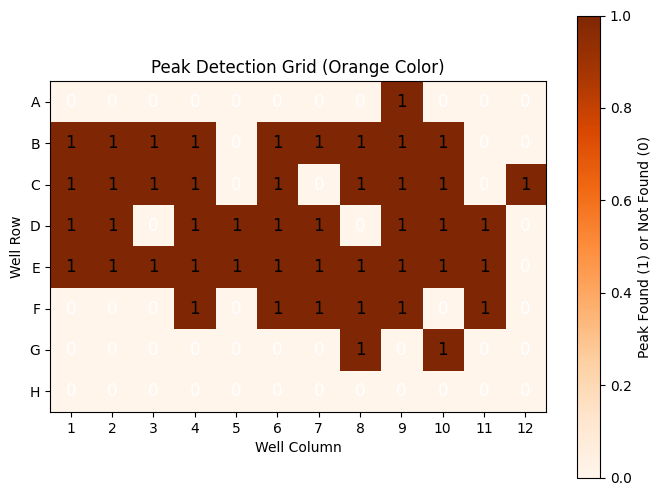

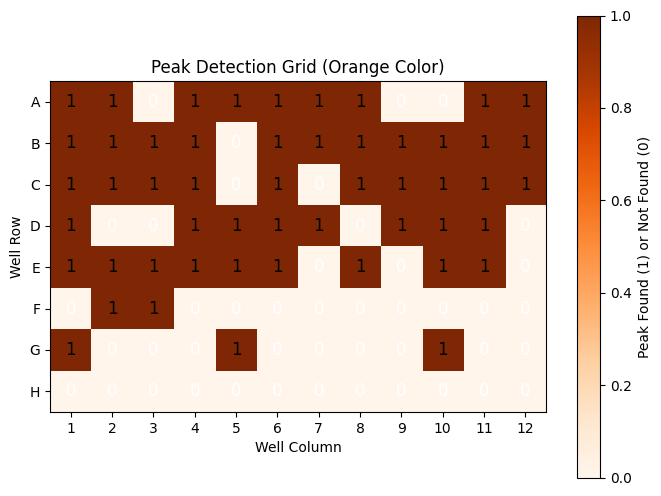

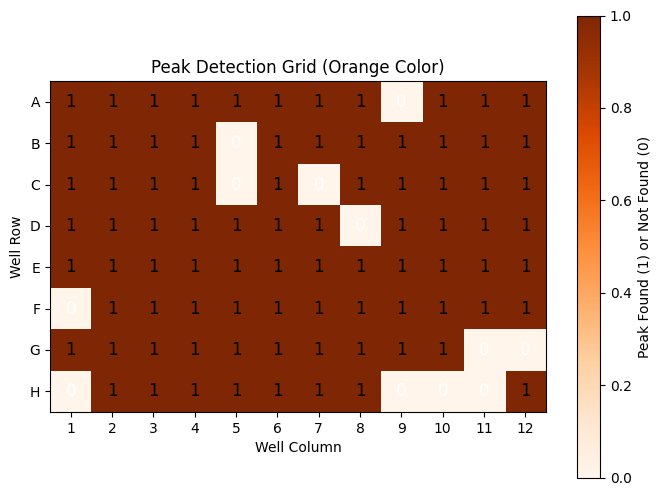

In [37]:
def draw_peak_grid(peaks):
    # Create an empty grid to represent the wells
    grid = np.zeros((8, 12), dtype=int)  # Assuming 8 rows (A-H) and 12 columns (1-12)
    
    for key, peak_info in peaks.items():
        # Extract the row and column indices from the key (e.g., 'A1' => row=0, col=0)
        row = ord(key[0]) - ord('A')
        col = int(key[1:]) - 1  # Subtract 1 because 1-based indexing
        
        # Check if peaks were found in this well
        if peak_info:
            grid[row, col] = 1  # Set to 1 if peaks were found
    
    # Create a grid plot with orange color
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap='Oranges', interpolation='none', aspect='equal')
    plt.xticks(np.arange(12), np.arange(1, 13))  # Label the columns as 1 to 12
    plt.yticks(np.arange(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])  # Label the rows as A to H
    plt.xlabel('Well Column')
    plt.ylabel('Well Row')
    plt.title('Peak Detection Grid (Orange Color)')
    
    # Add text labels indicating presence or absence of peaks
    for i in range(8):
        for j in range(12):
            plt.text(j, i, str(grid[i, j]), va='center', ha='center', fontsize=12, color='white' if grid[i, j] == 0 else 'black')

    plt.colorbar(label='Peak Found (1) or Not Found (0)')
    plt.show()

# Example usage:
# Assuming you have a 'peaks' dictionary with keys like 'A1', 'B2', etc.
draw_peak_grid(peaks1)
draw_peak_grid(peaks2)
draw_peak_grid(peaks3)

In [15]:
def plot_chromatography_data(data,index = 2):
    # Number of rows and columns for the subplot grid
    n_rows = 8  # For wells A to H
    n_cols = 12 # For wells 1 to 12

    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Iterate over the dictionary to plot each well's data
    for well_position, values in data.items():
        # Determine the row and column for the subplot
        row = ord(well_position[0]) - ord('A') # Convert 'A'-'H' to 0-7
        col = int(well_position[1:]) - 1       # Convert '1'-'12' to 0-11

        # Plot the data in the corresponding subplot
        axs[row, col].plot(values[:, 0], values[:, index])
        if(well_position[0] == "A"):
            axs[row, col].set_title(well_position)
        #axs[row, col].set_xlabel('Time (s)')
        #axs[row, col].set_ylabel('Absorbance')
    
    plt.show()

def plot_single_well(data, well_position):
    # Check if the specified well position is in the data
    if well_position in data:
        # Plot the data for the specified well
        plt.figure(figsize=(6, 4))
        plt.plot(data[well_position][:, 0], data[well_position][:, 1])
        plt.title(f"{well_position}")
        plt.xlabel('Time (s)')
        plt.ylabel('Absorbance')
        plt.show()
    else:
        print(f"No data found for well {well_position}")

def plot_baseline_overlay(x, y, baseline):
    
    plt.plot(x, y, label='raw data', lw=1.5)
    plt.plot(x, baseline, '--', label='modpoly')
    plt.plot(x, y-baseline, label='adjusted data', lw=1.5)

    plt.legend()
    plt.show()

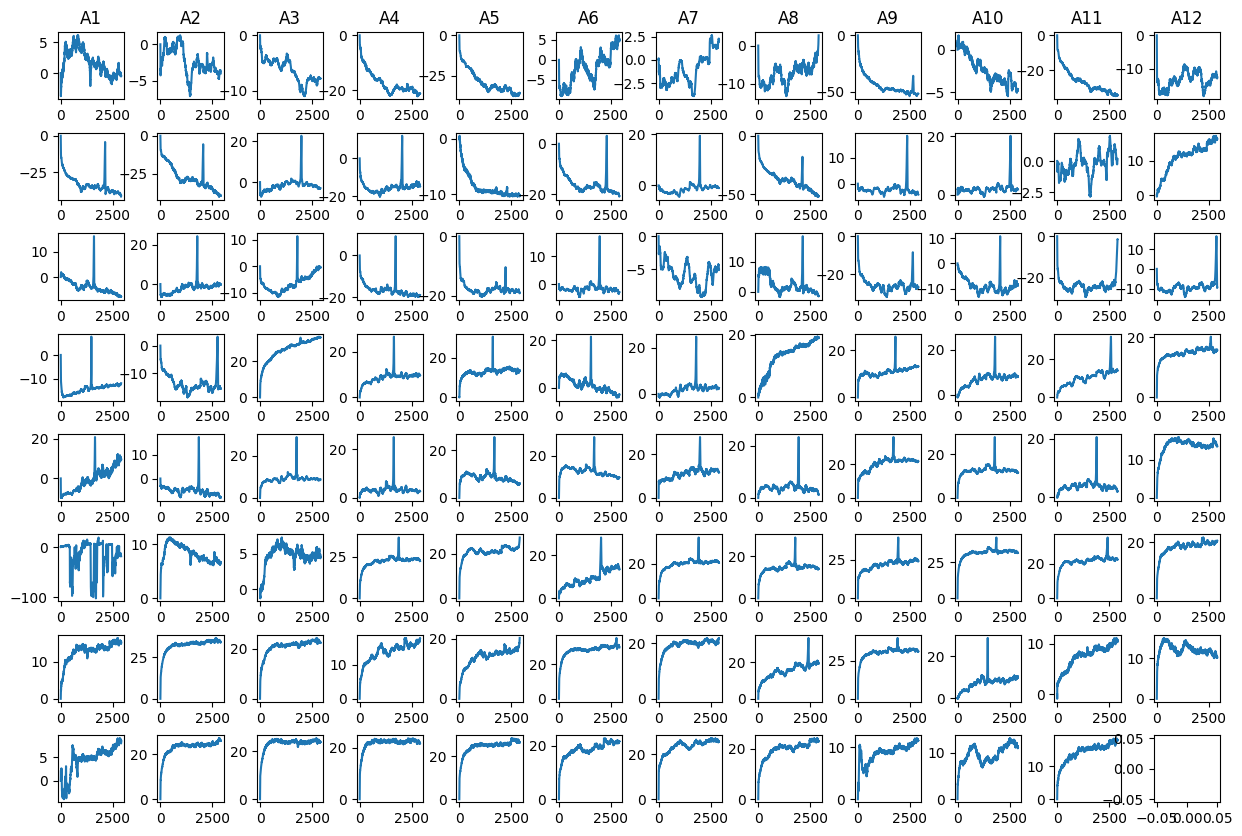

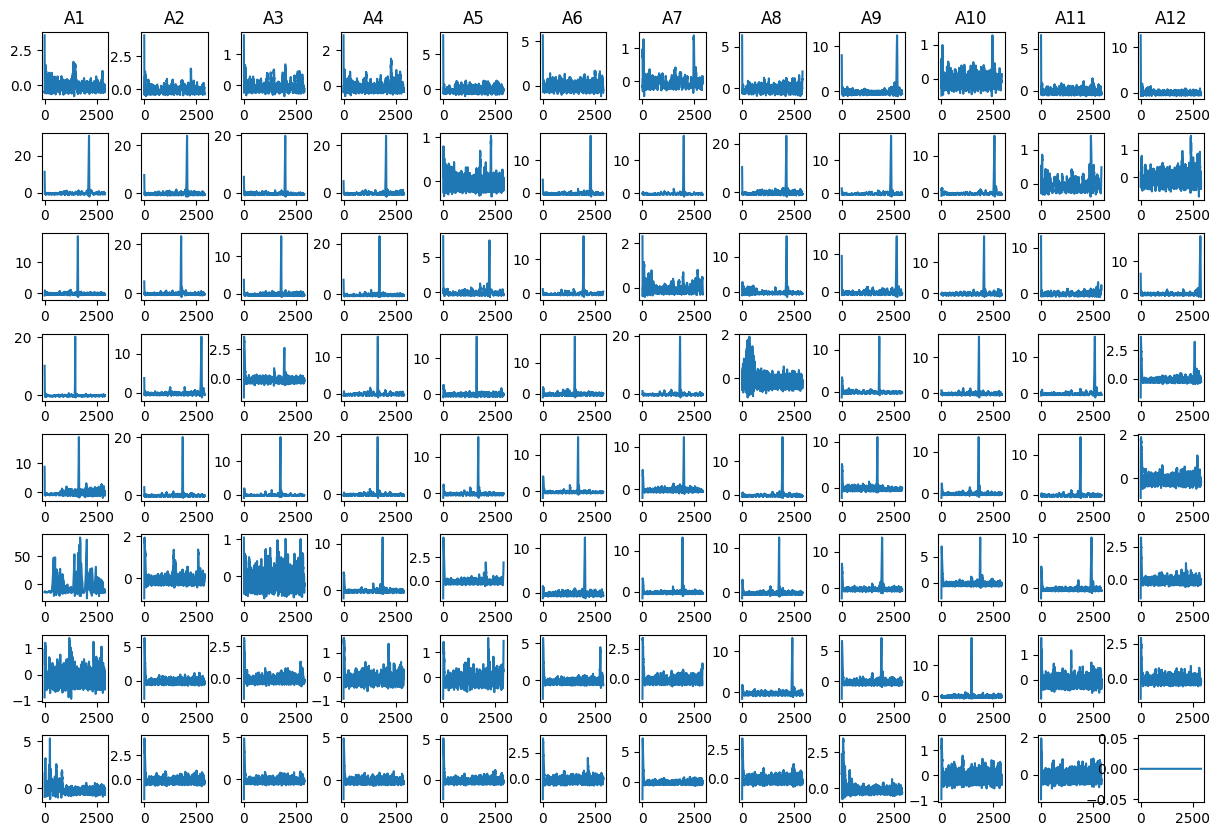

In [38]:
plot_chromatography_data(processed_data1,index=1)
plot_chromatography_data(processed_data1,index=2)

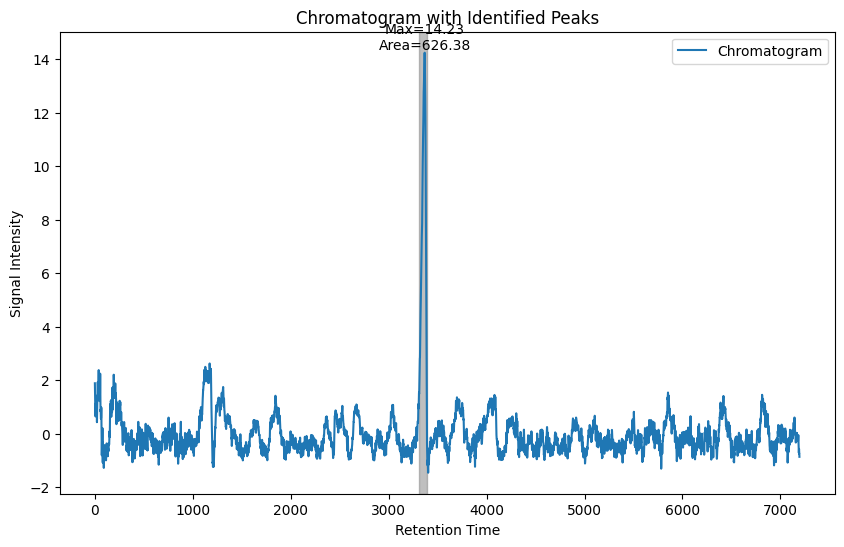

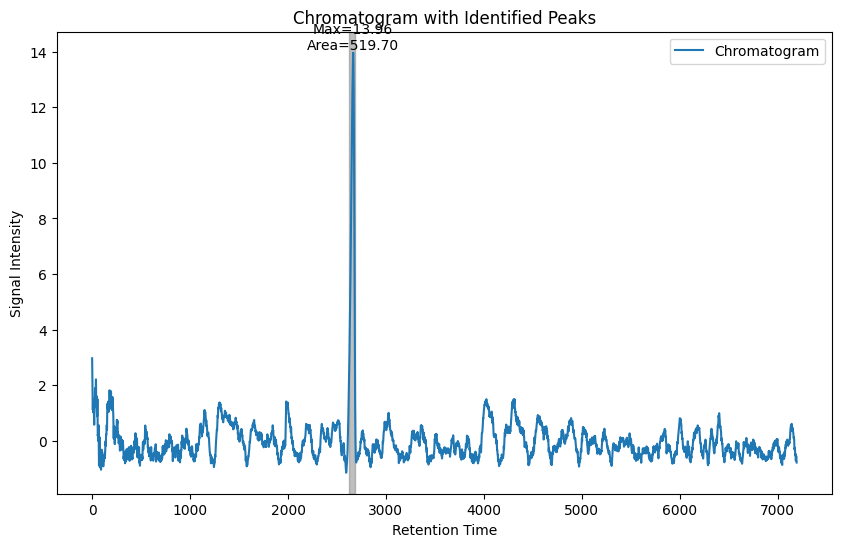

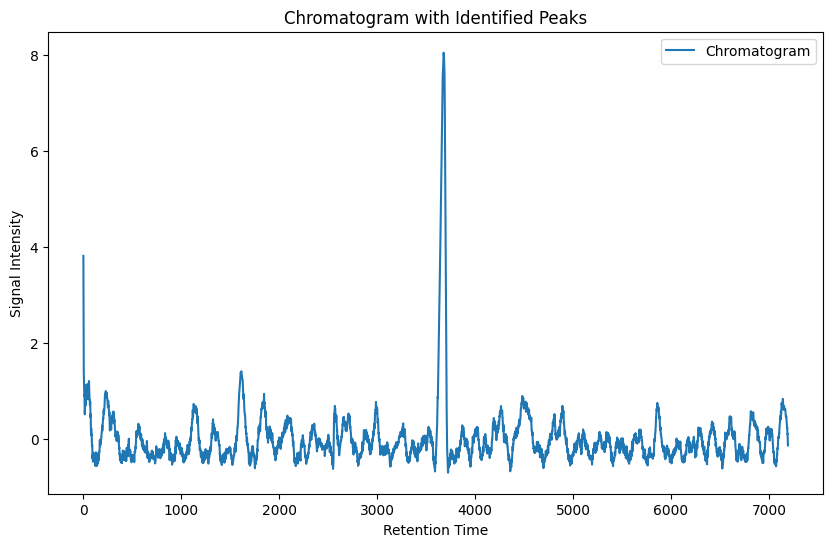

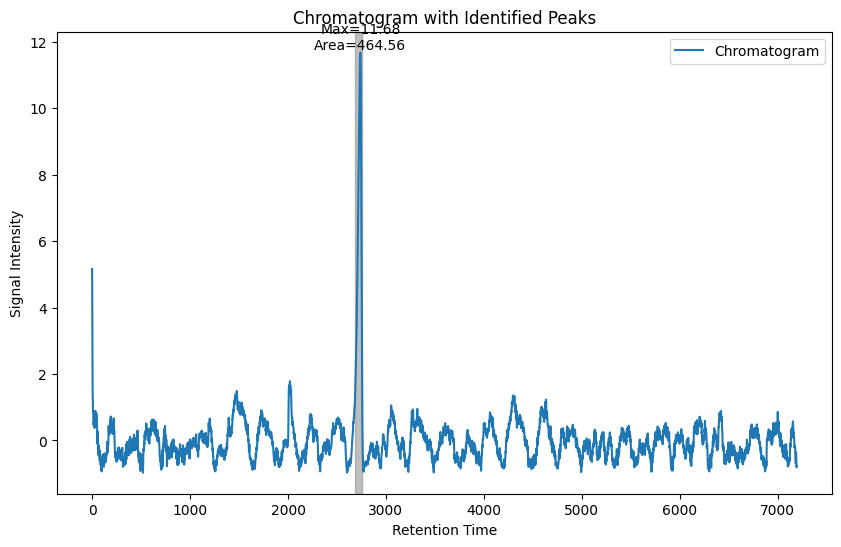

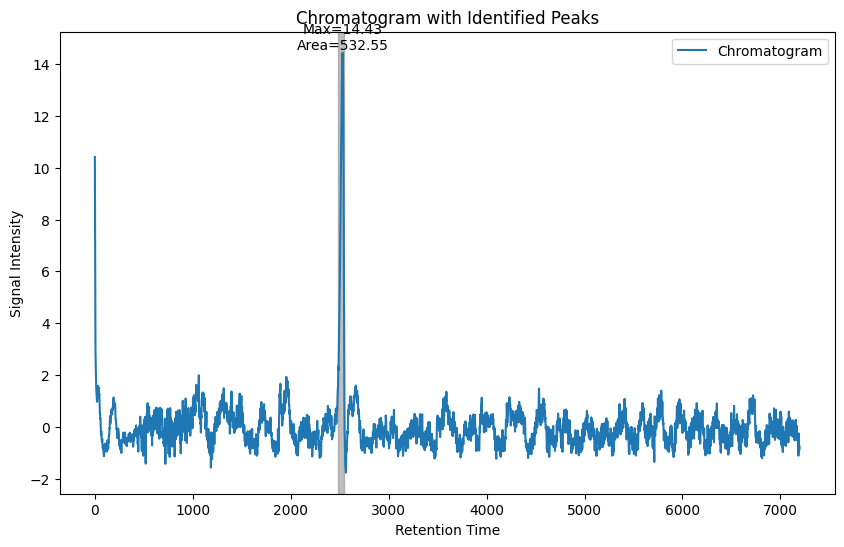

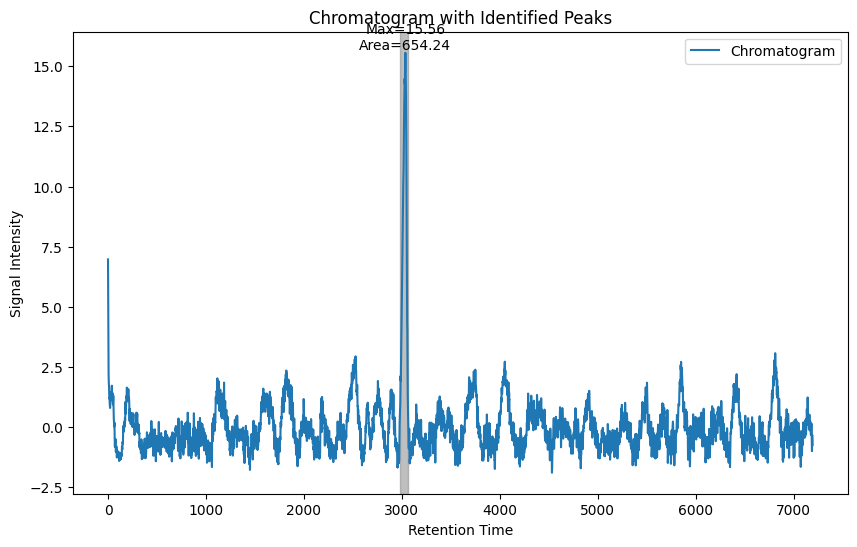

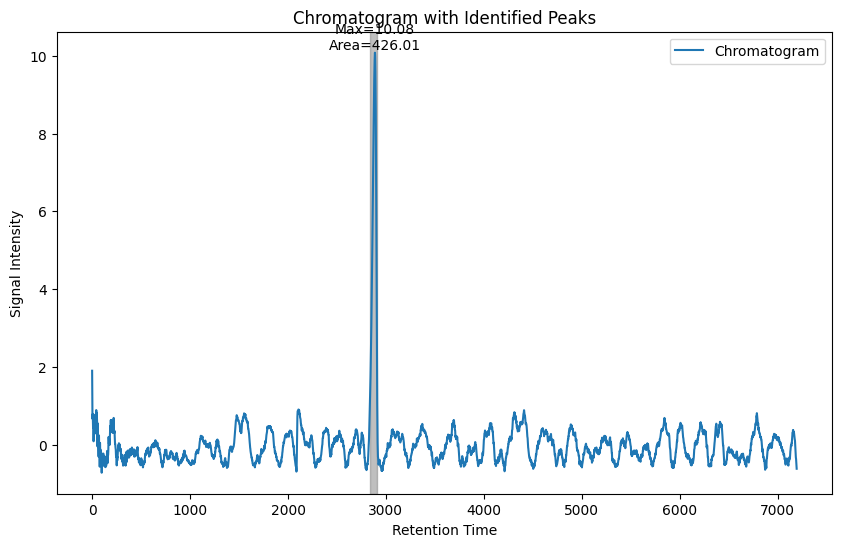

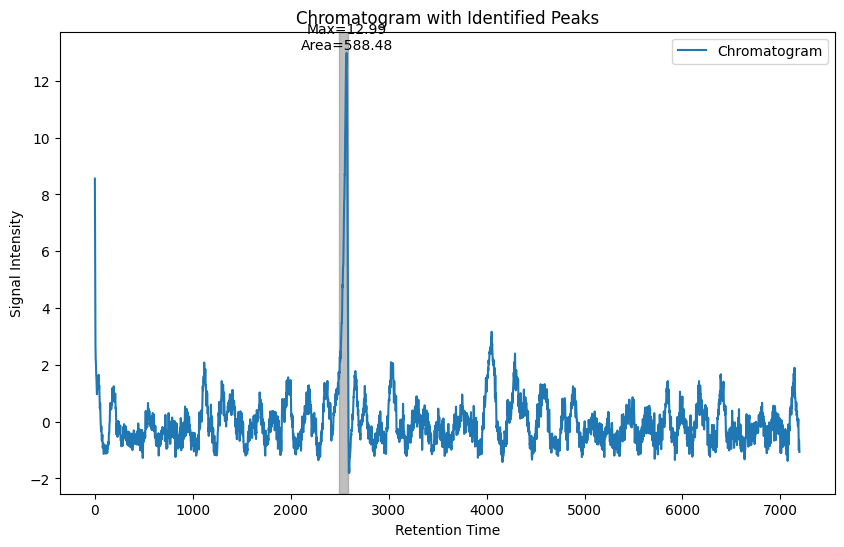

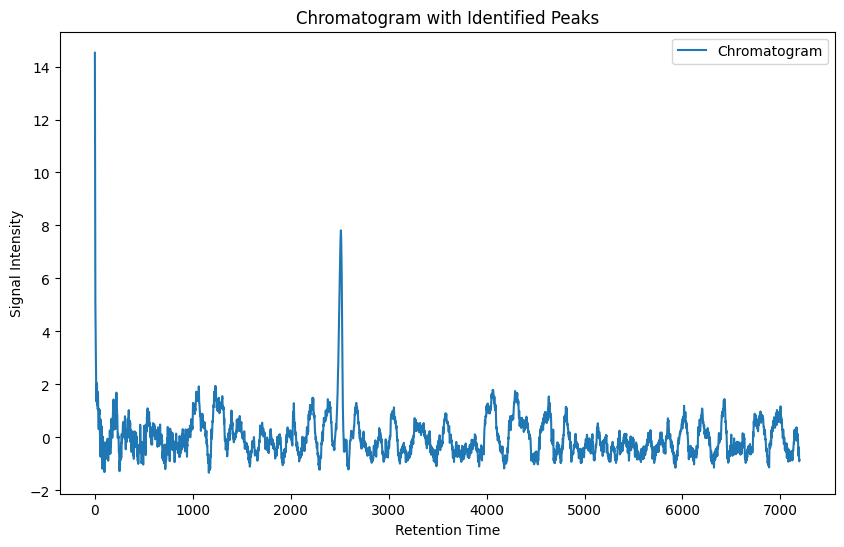

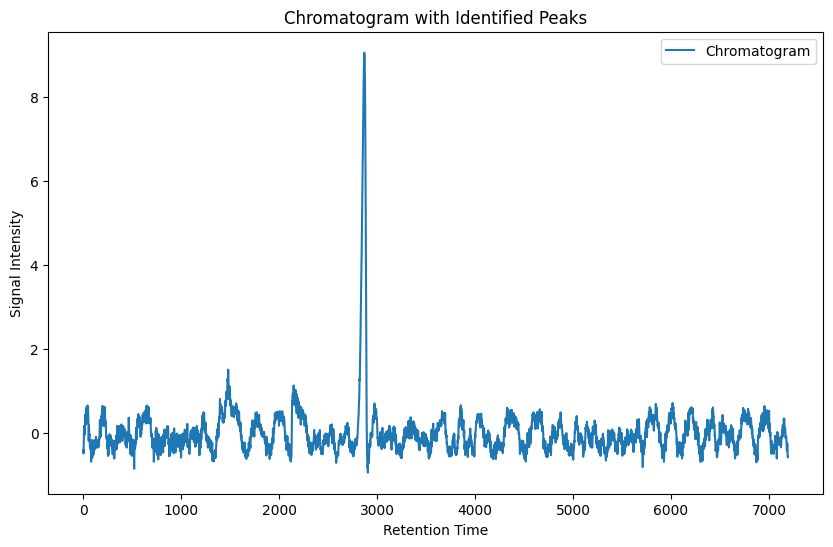

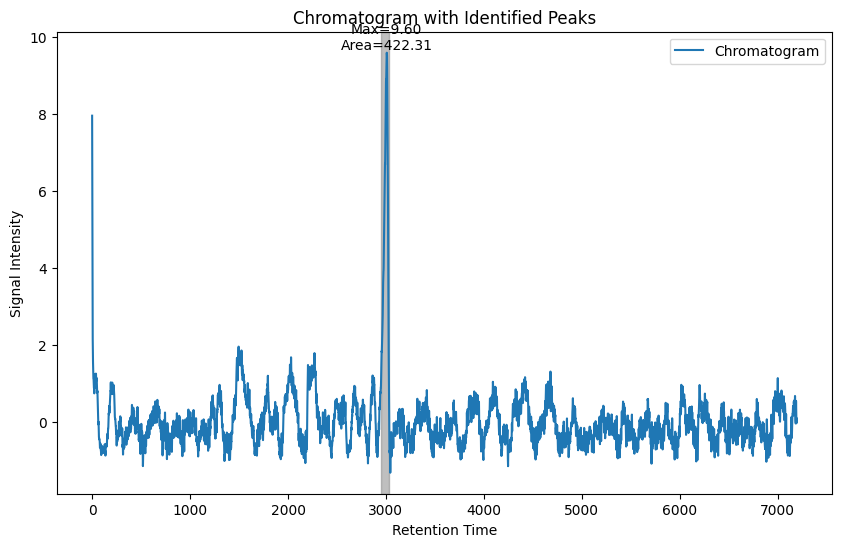

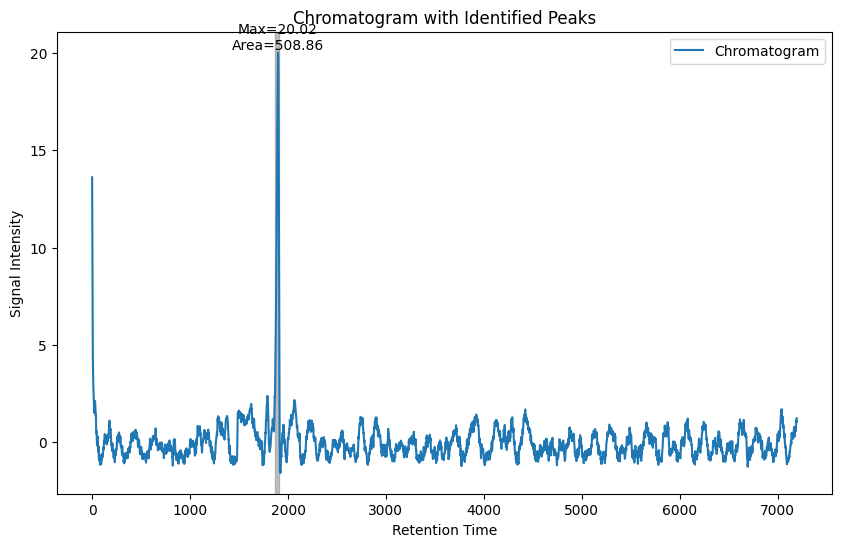

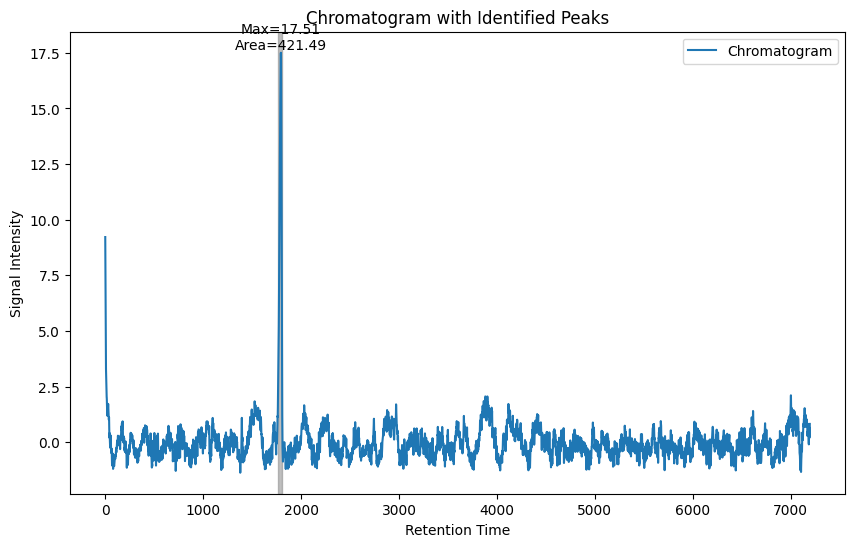

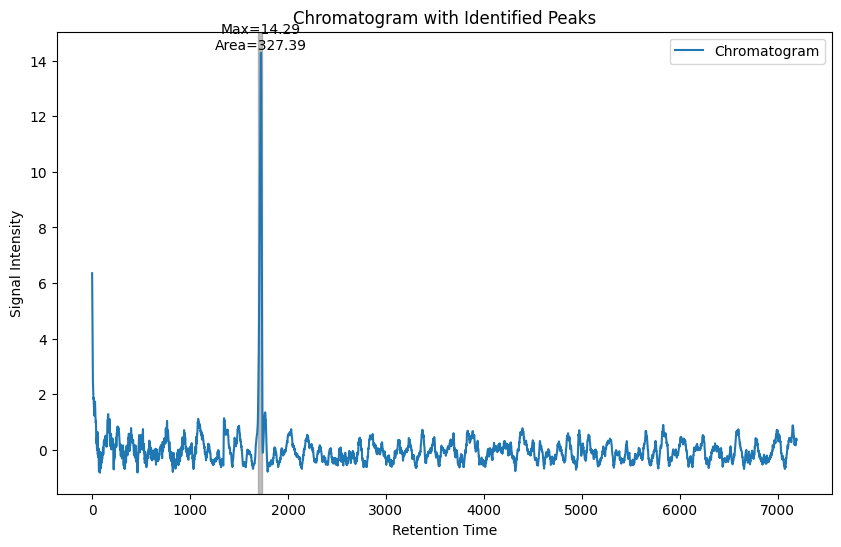

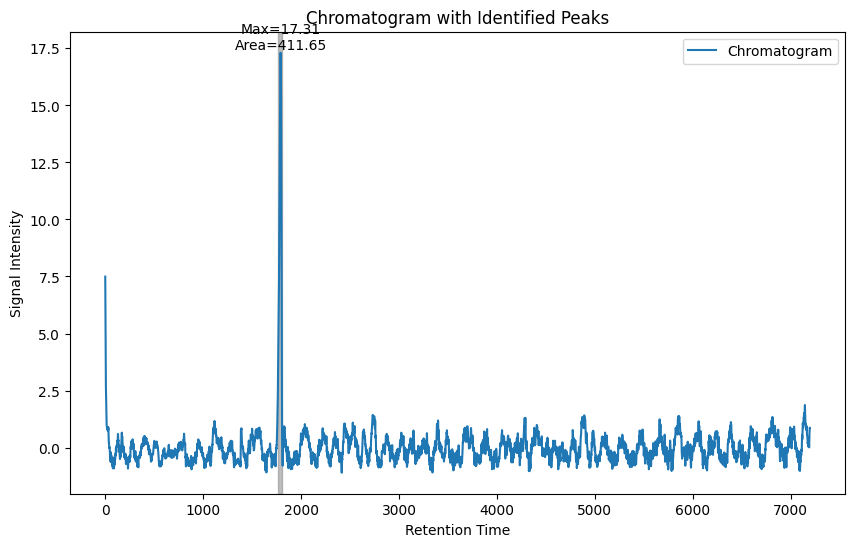

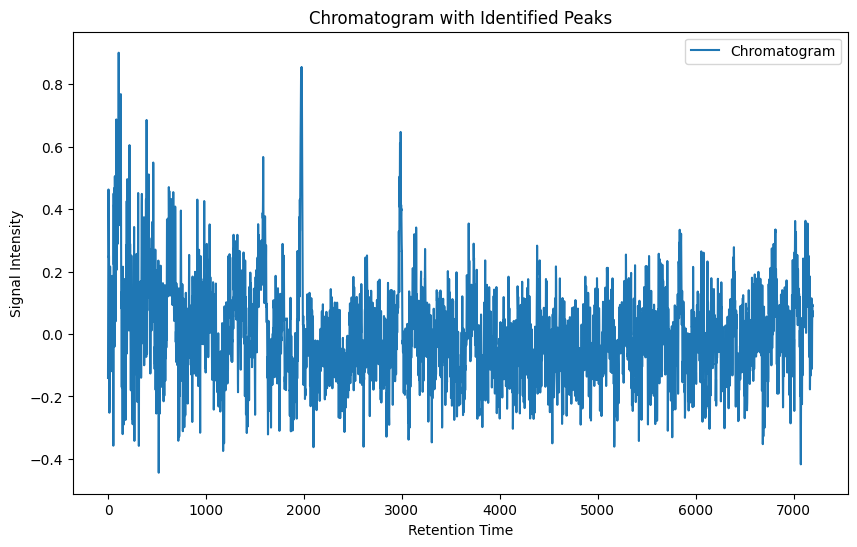

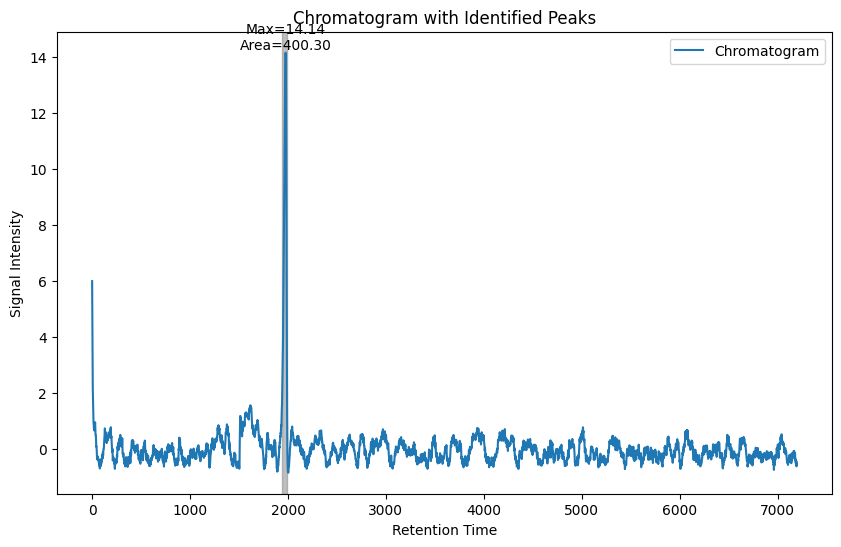

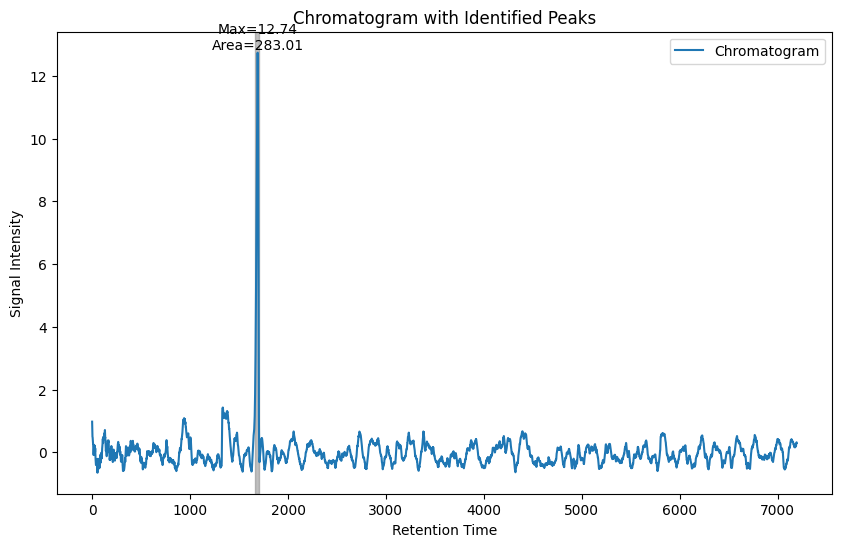

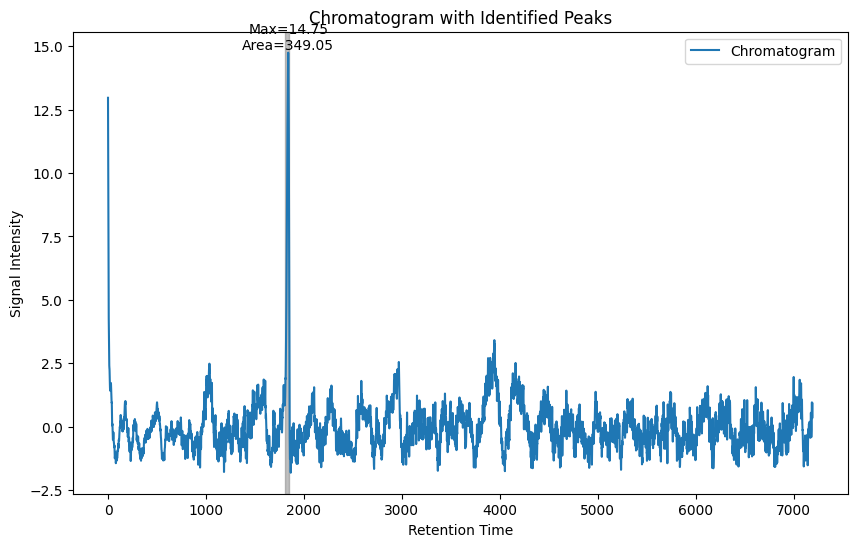

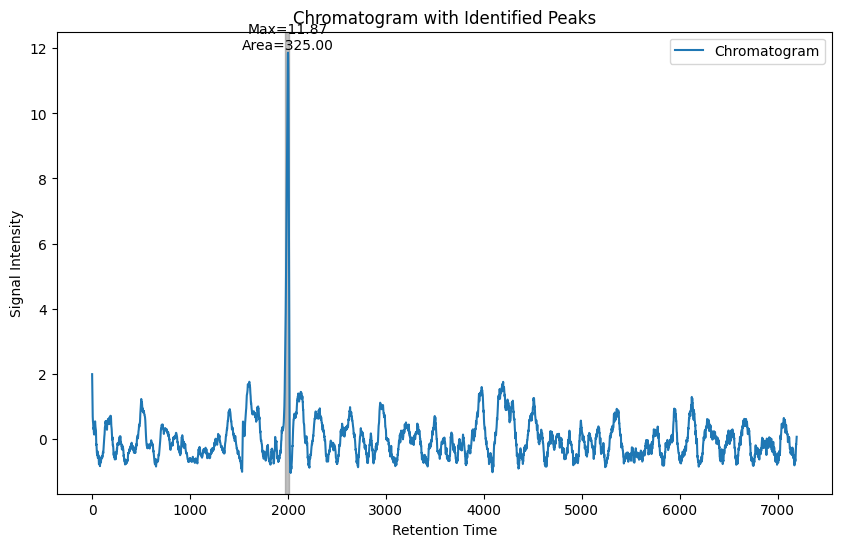

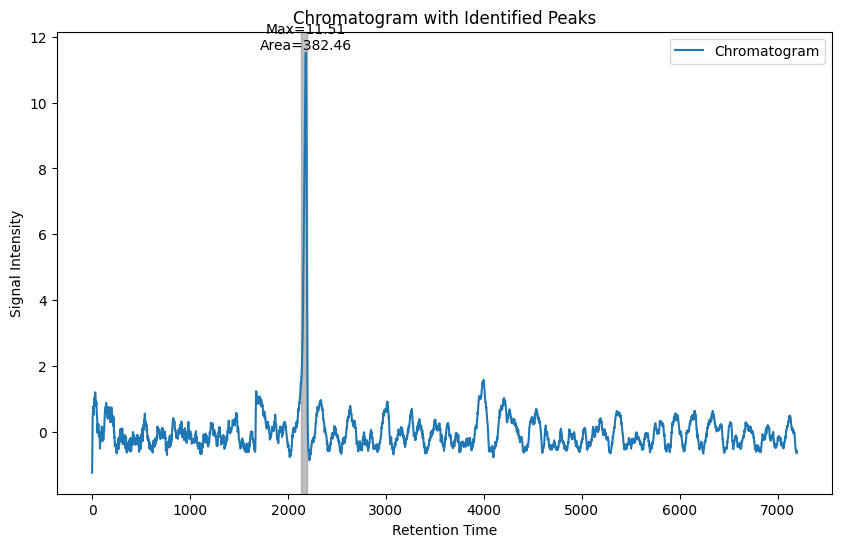

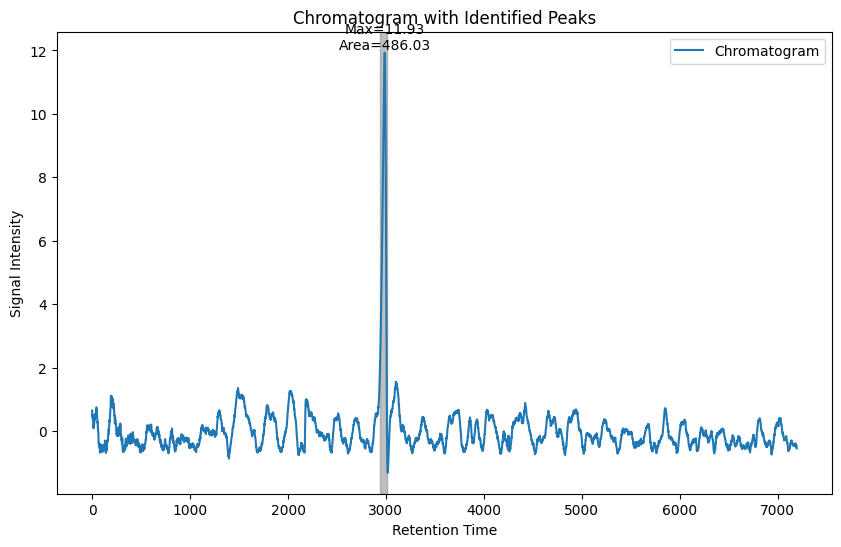

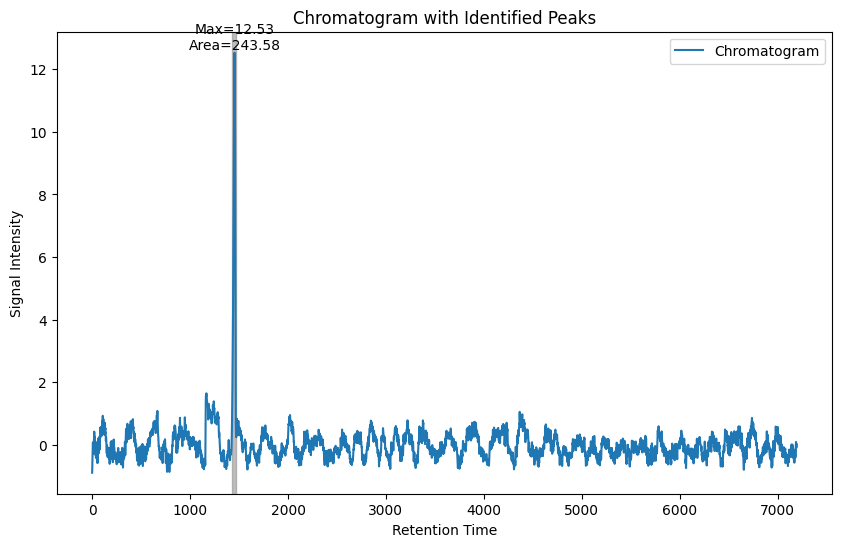

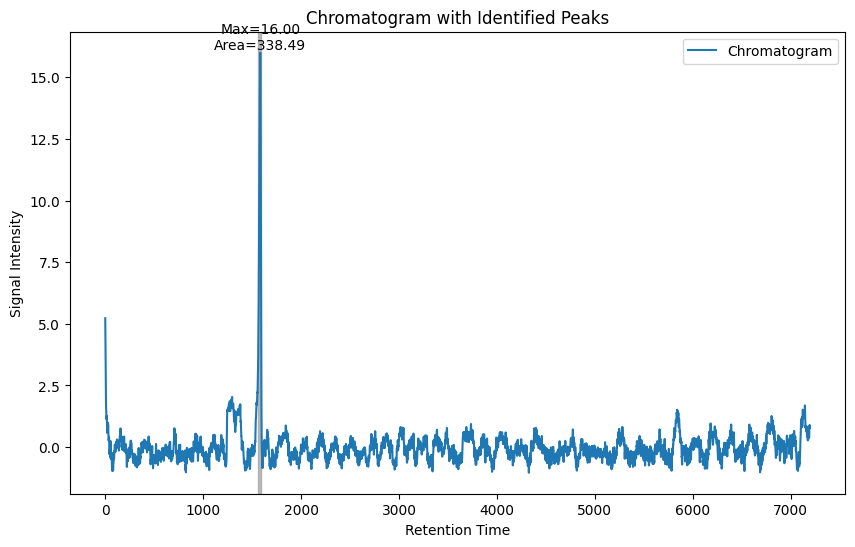

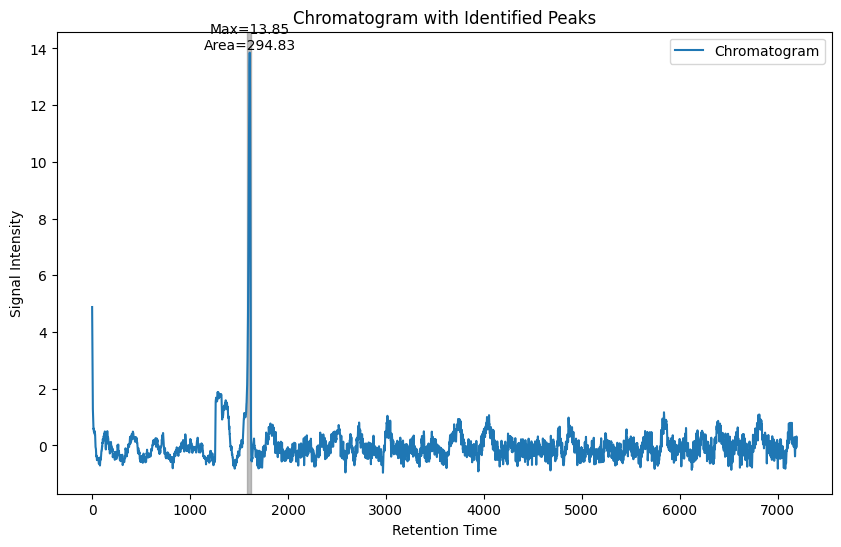

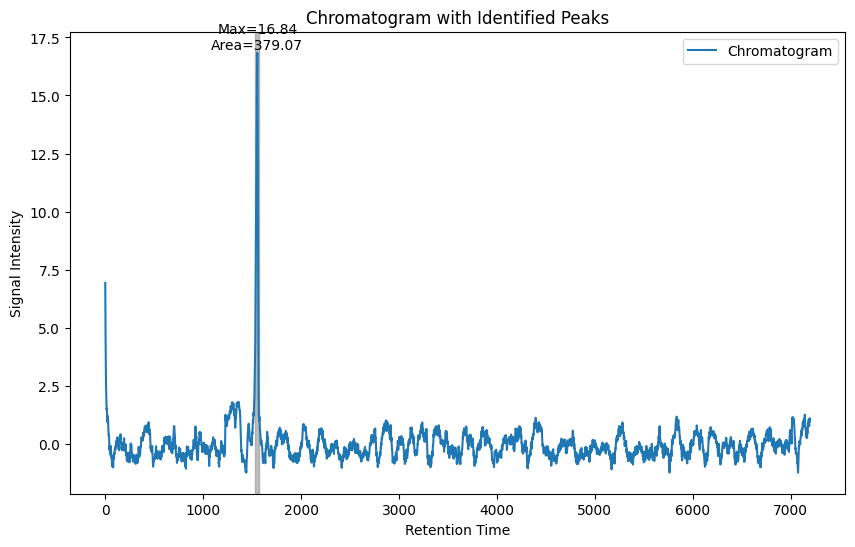

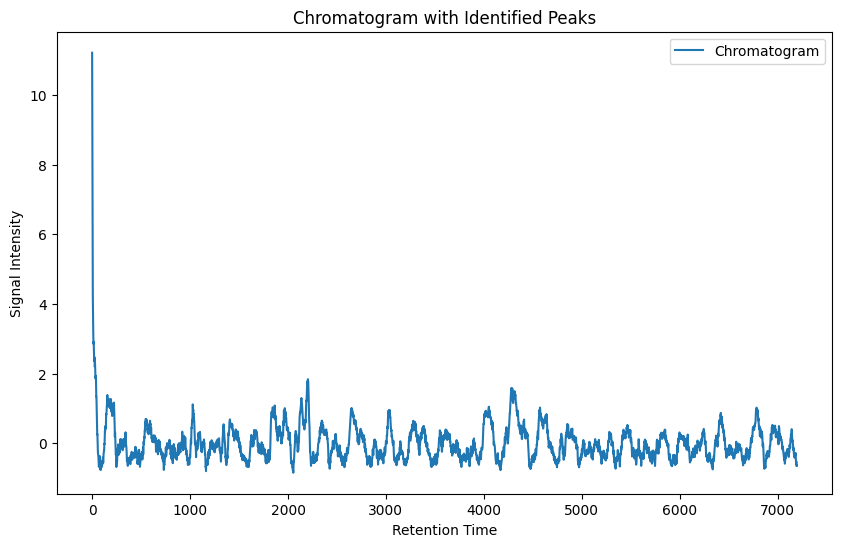

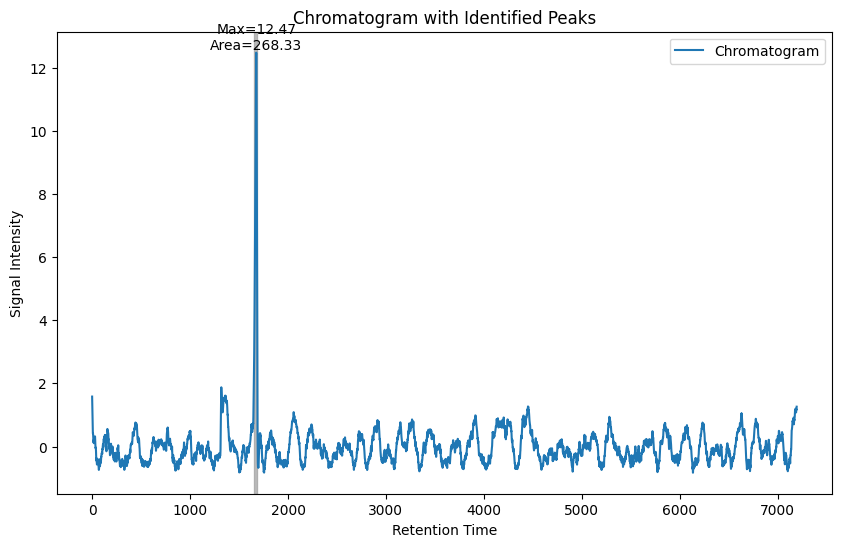

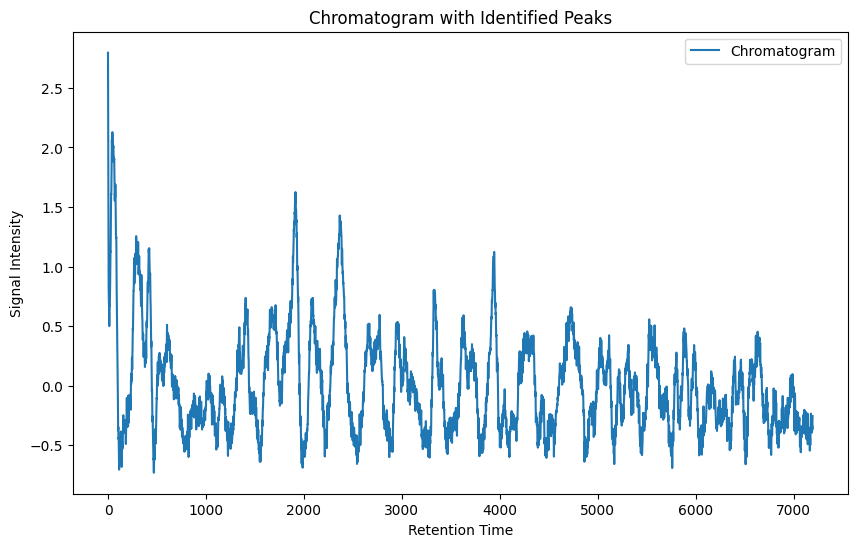

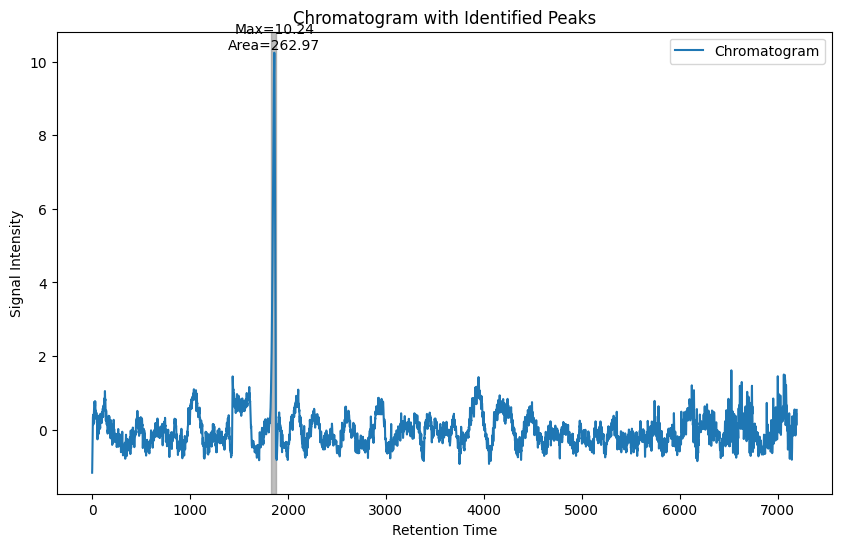

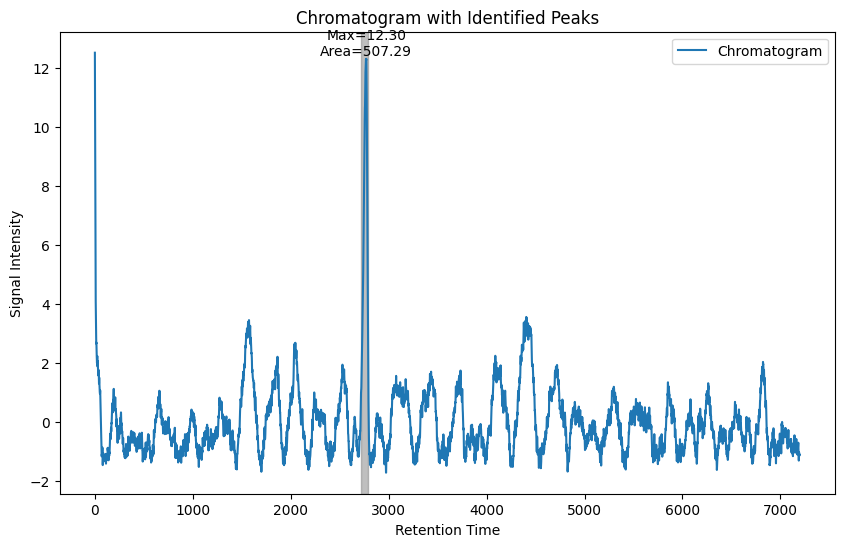

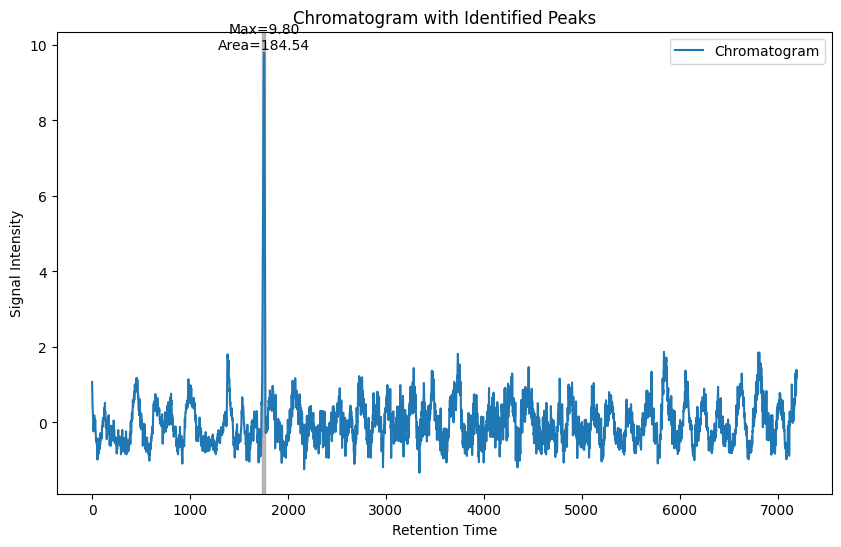

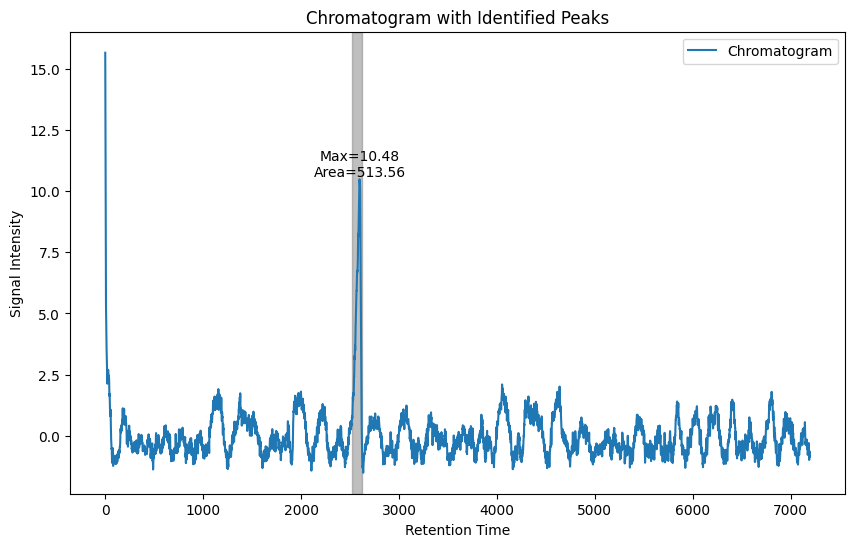

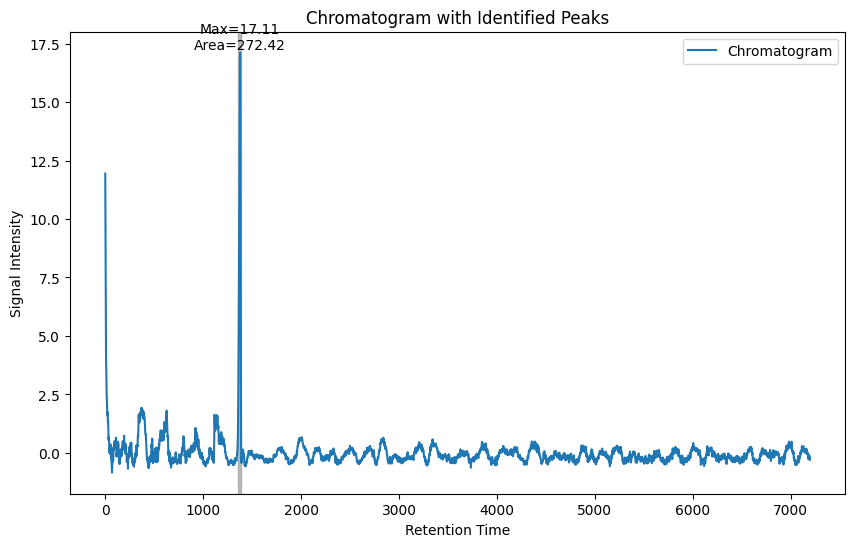

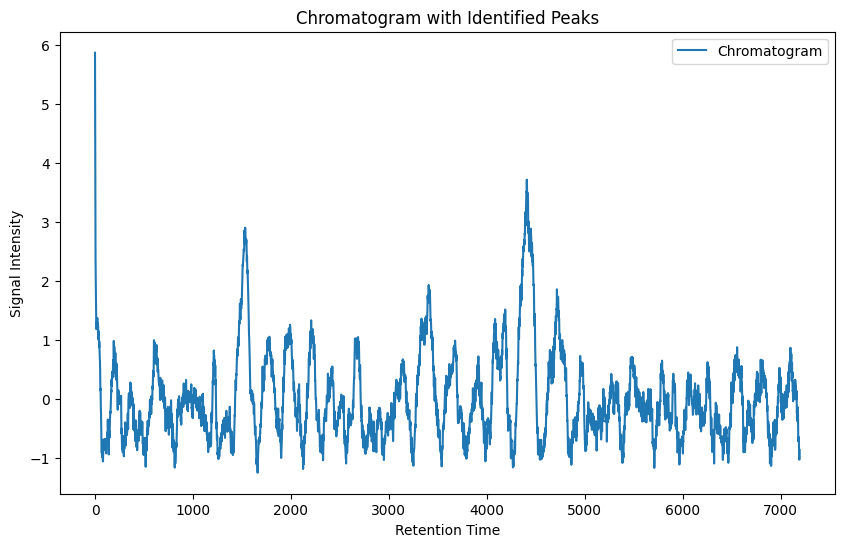

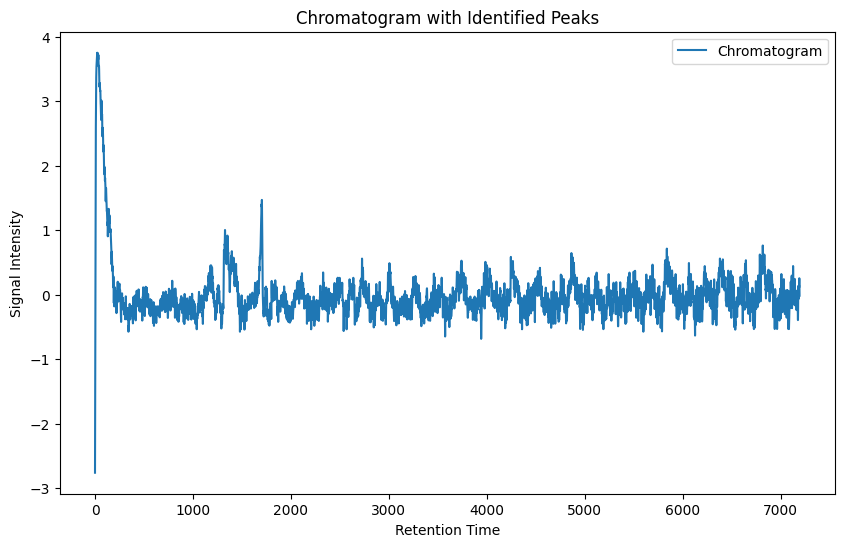

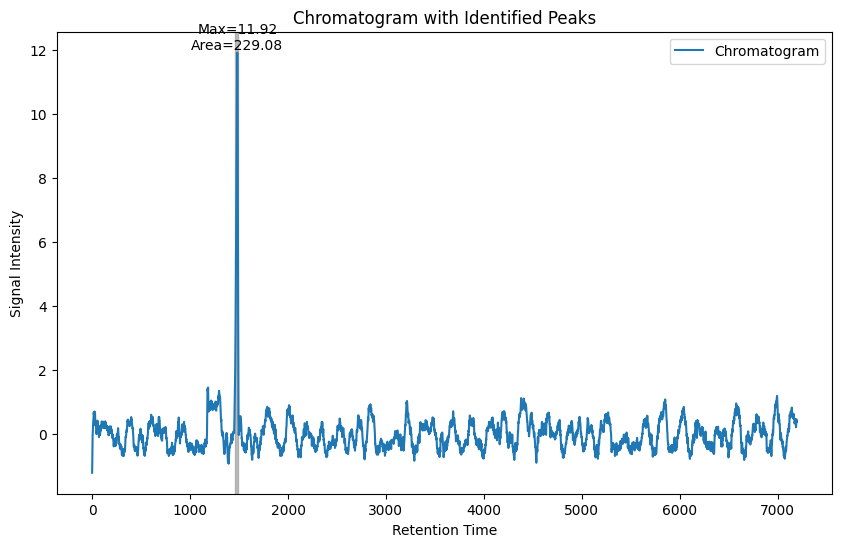

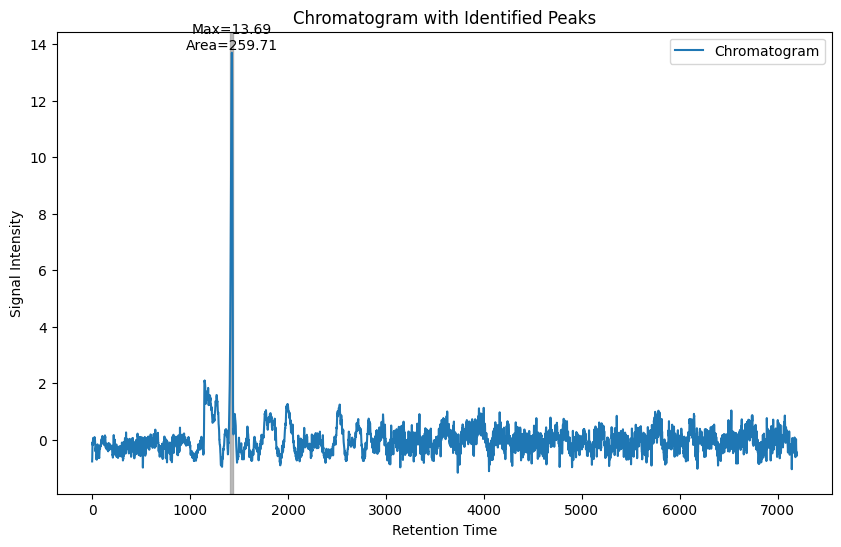

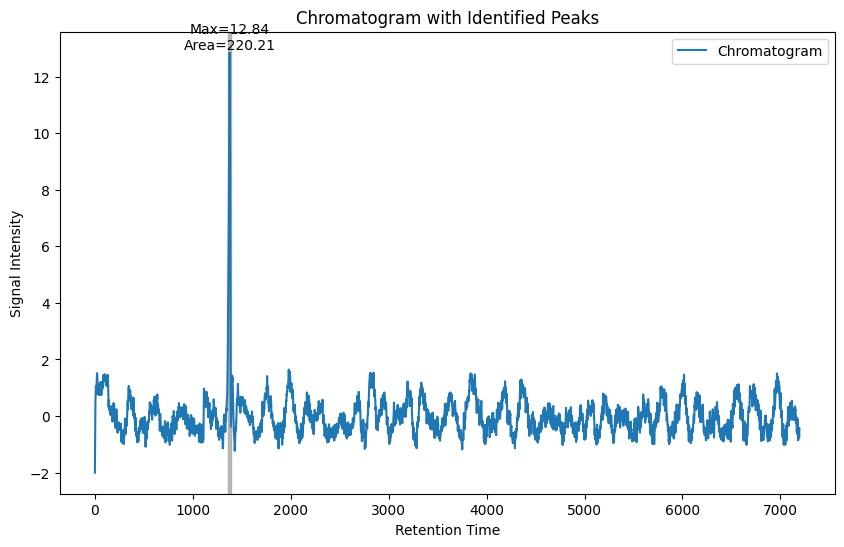

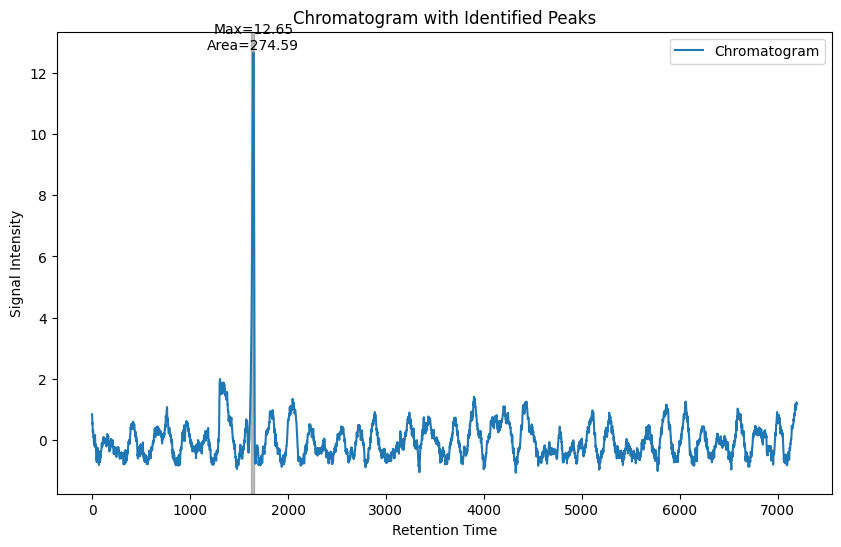

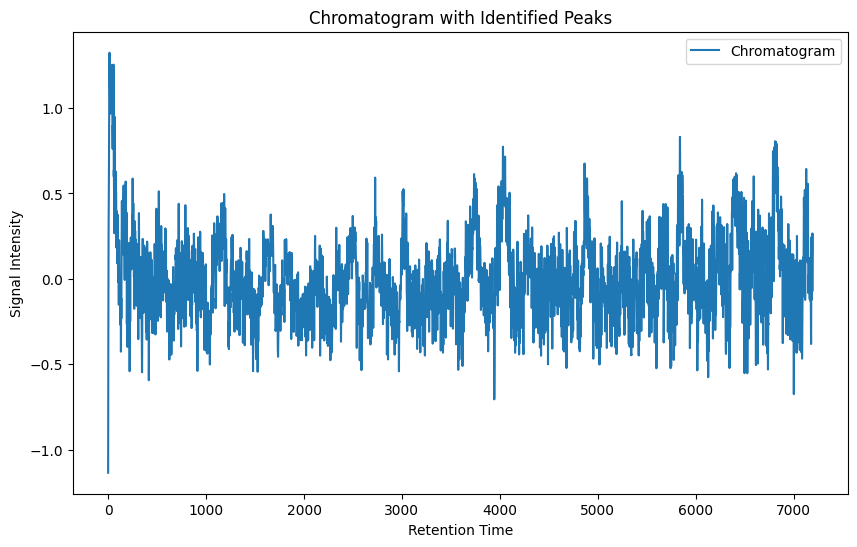

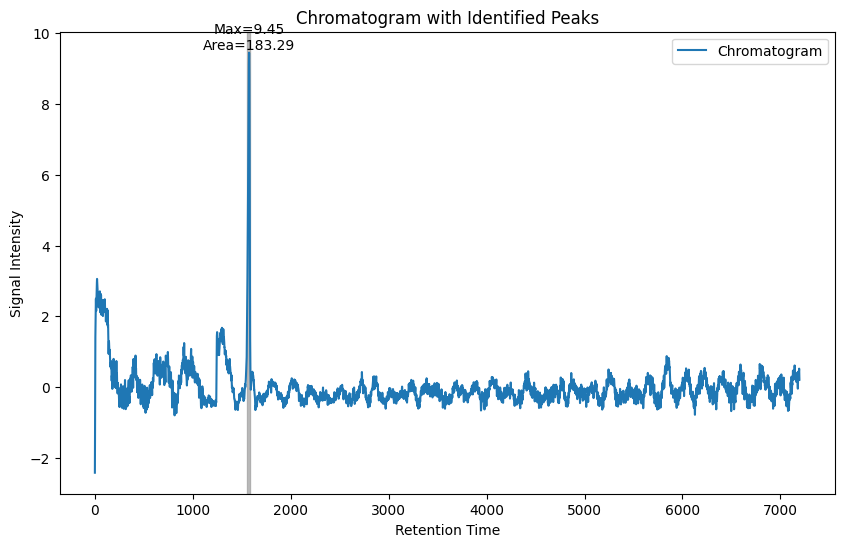

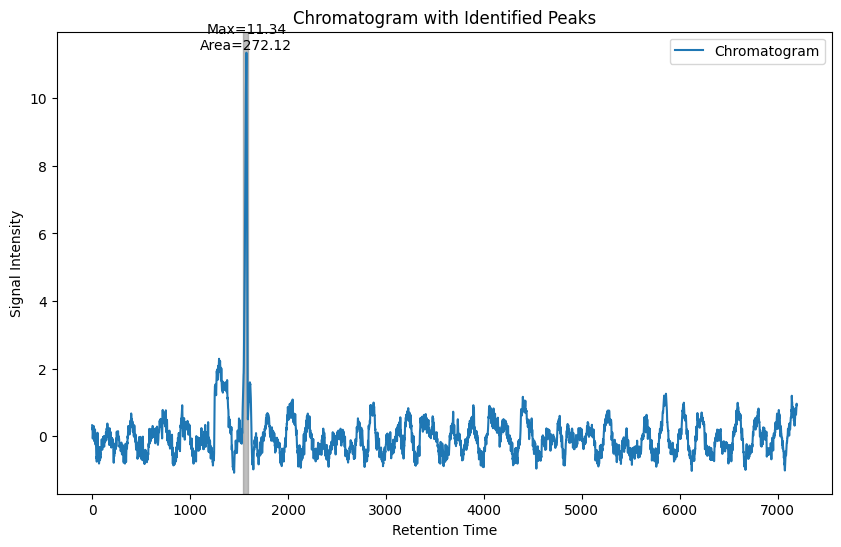

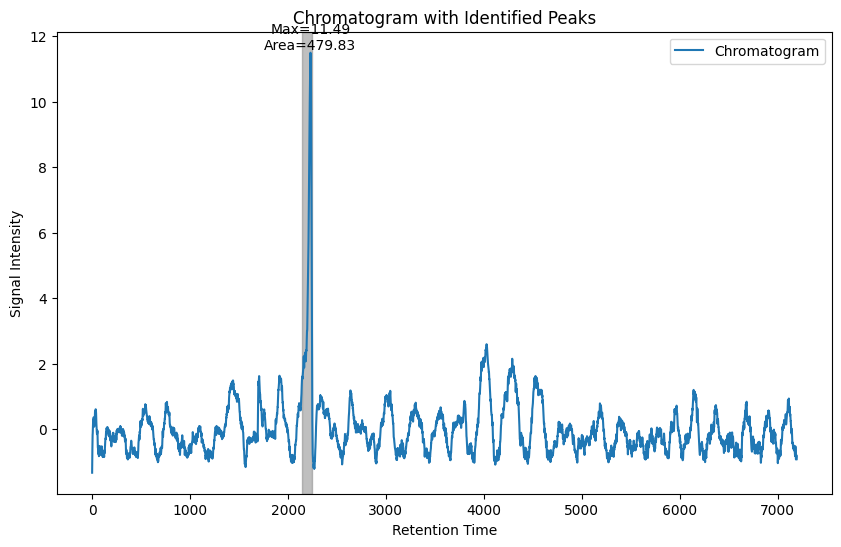

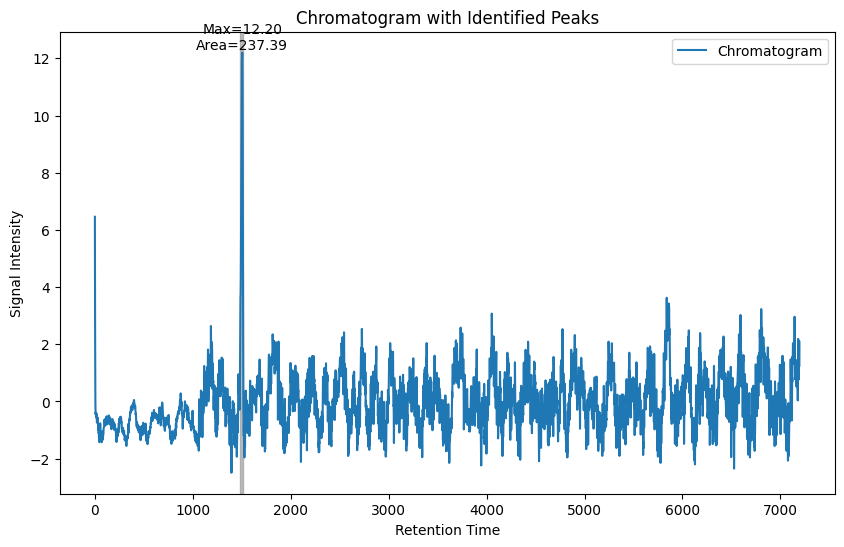

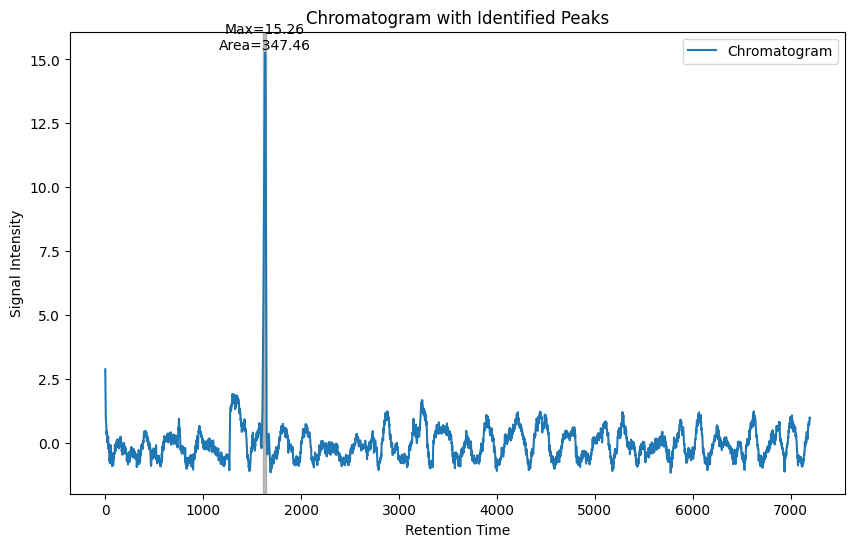

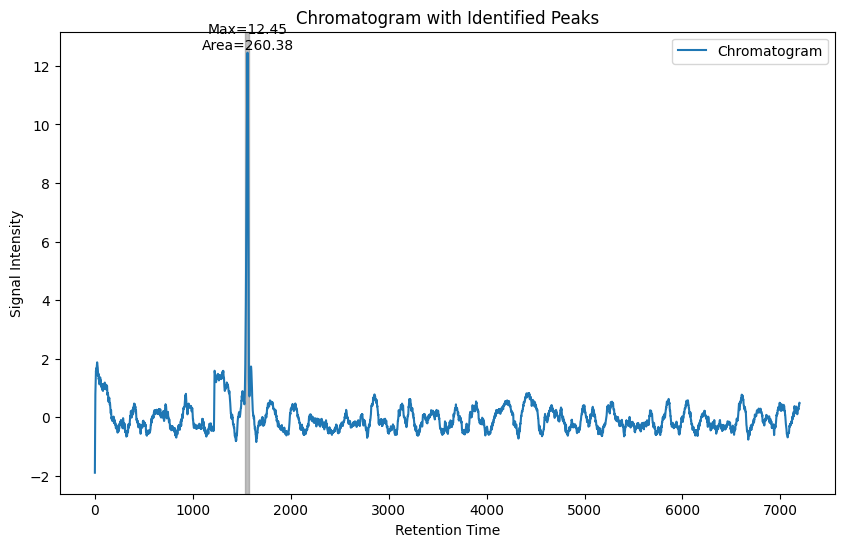

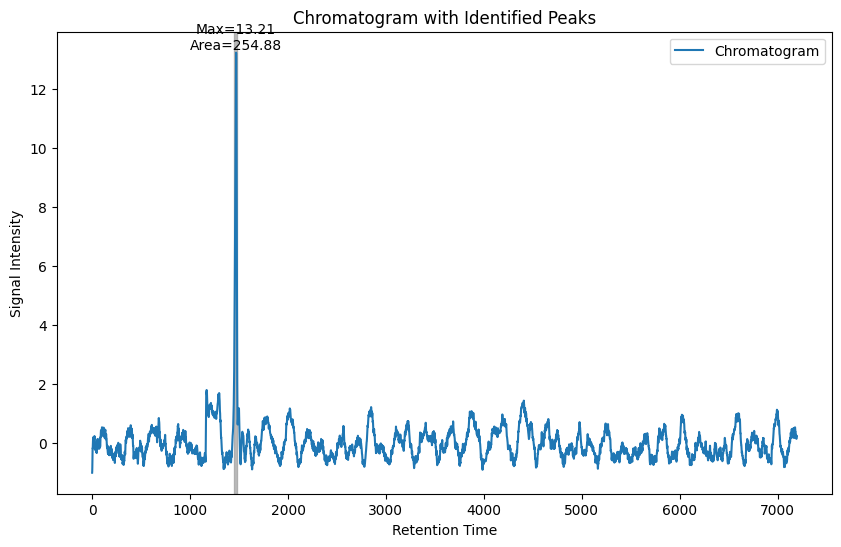

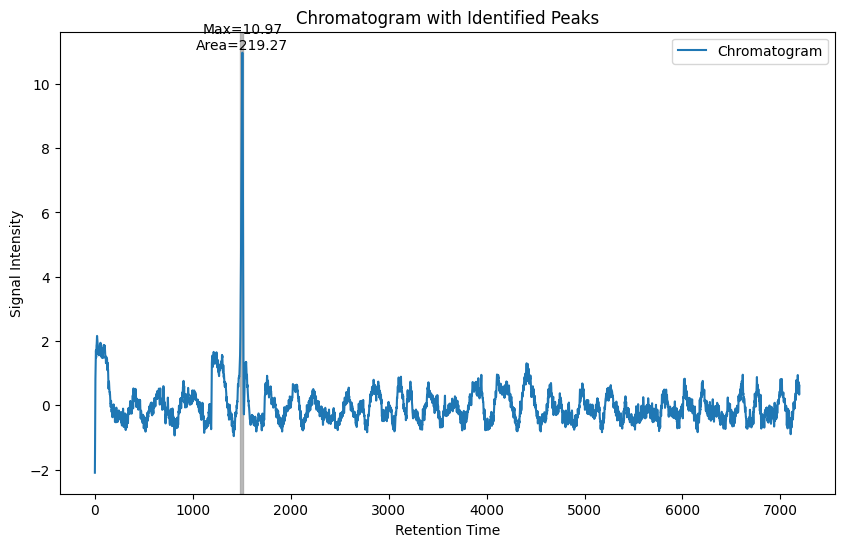

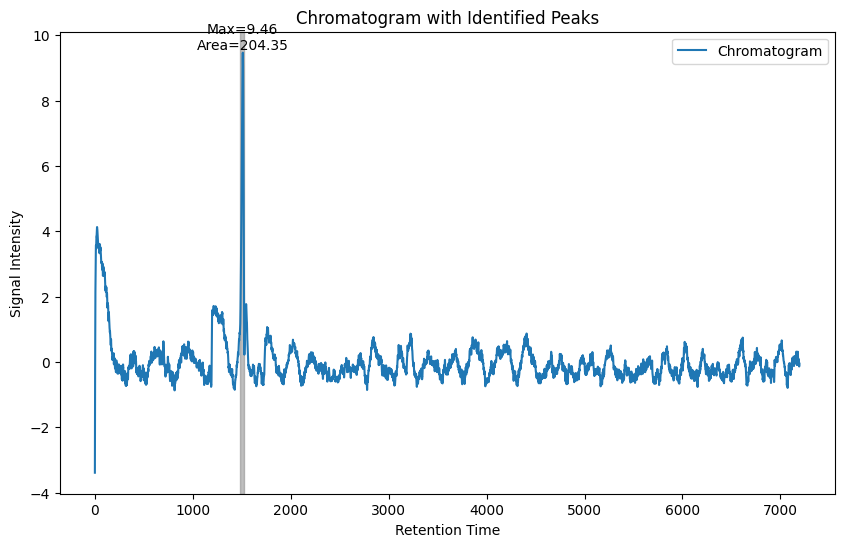

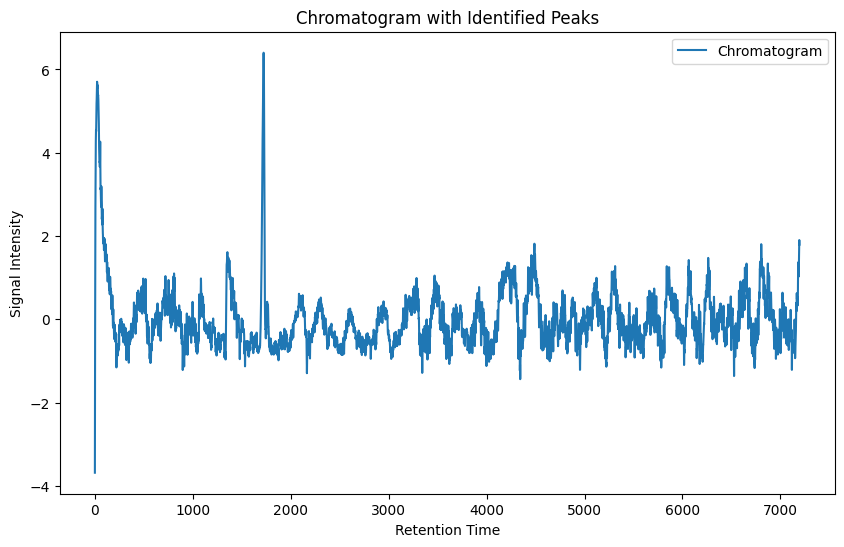

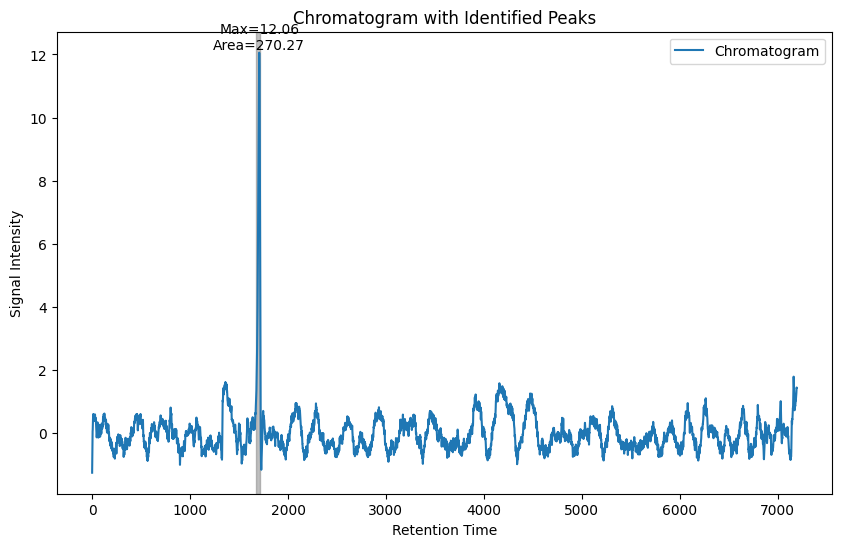

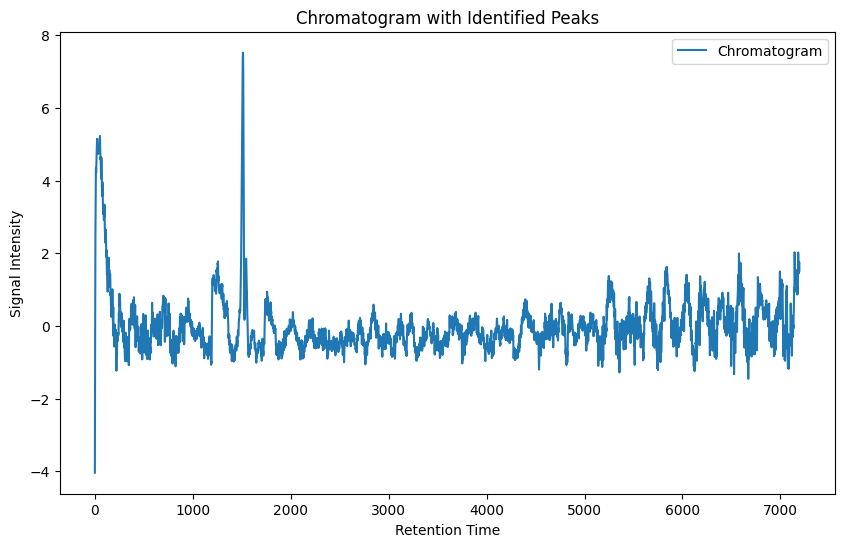

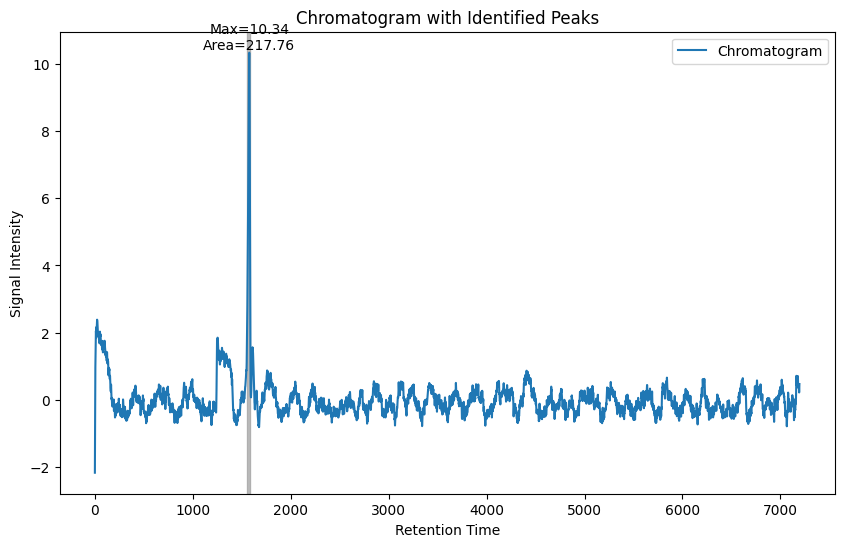

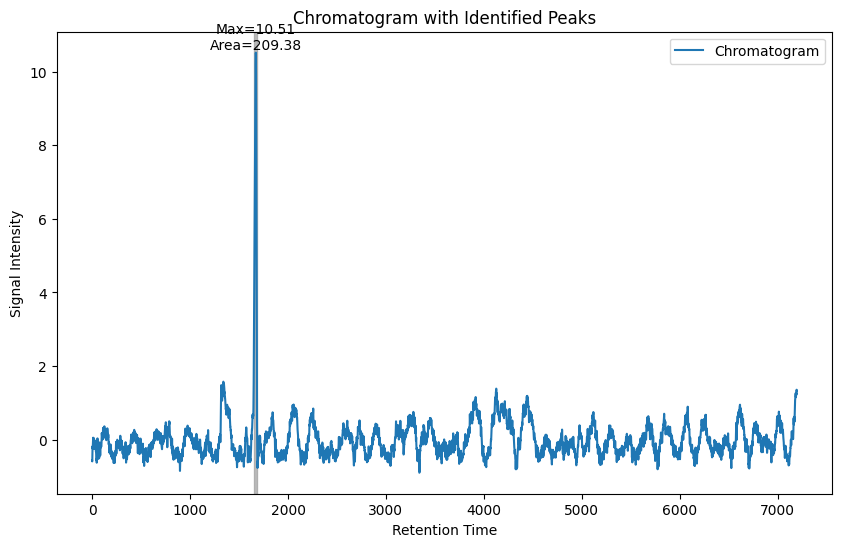

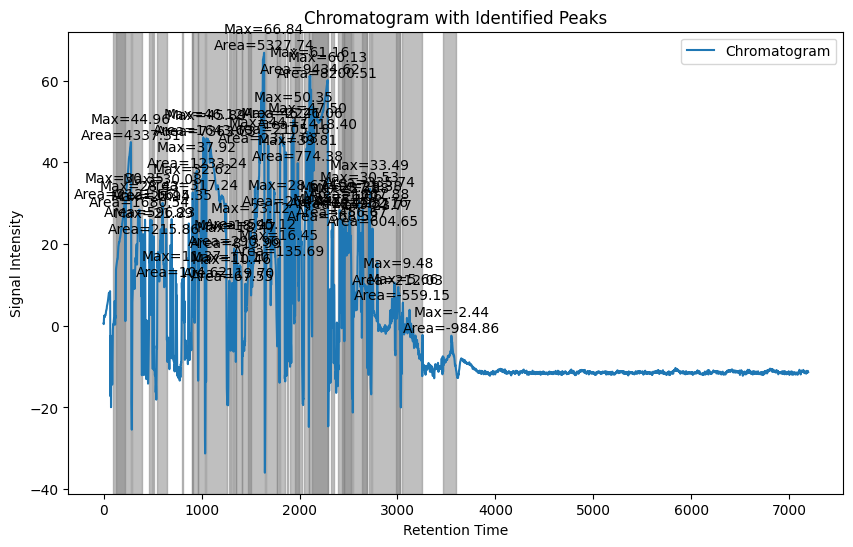

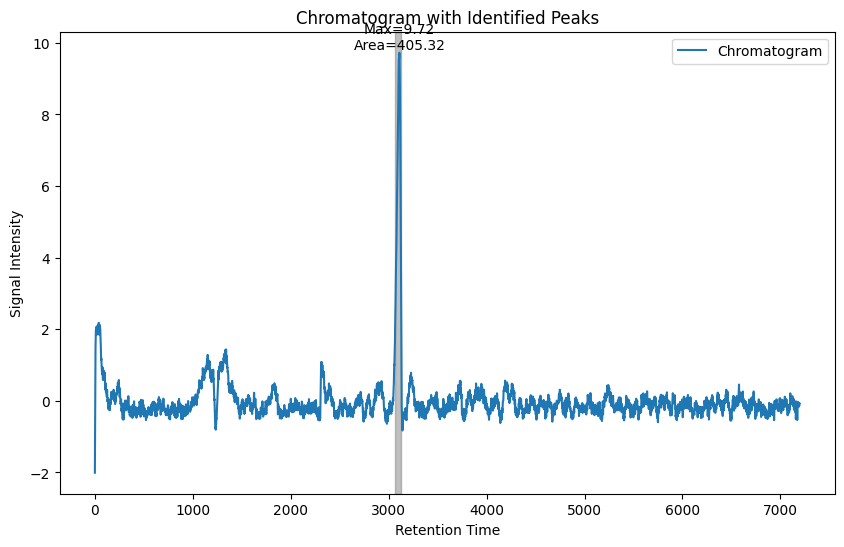

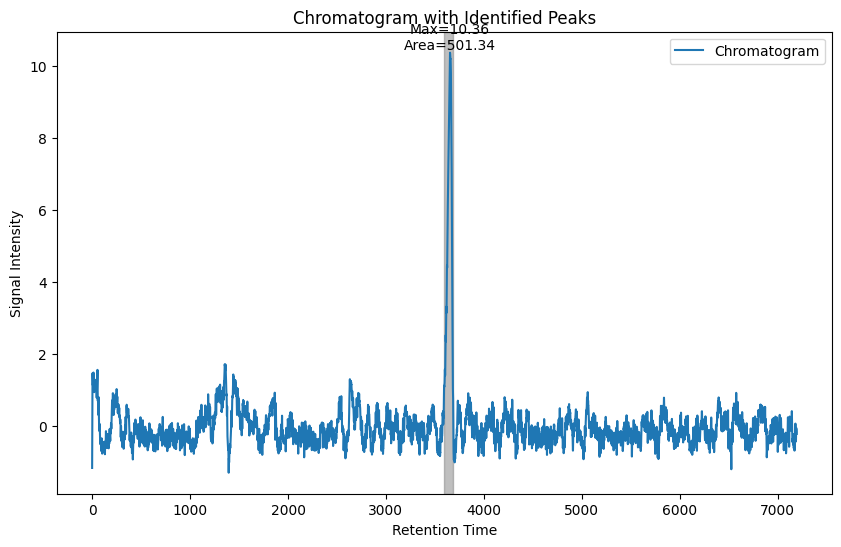

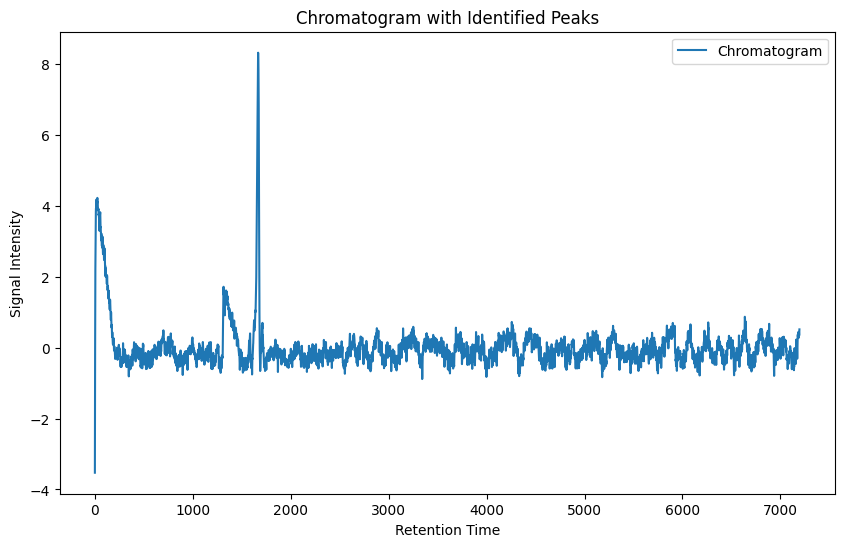

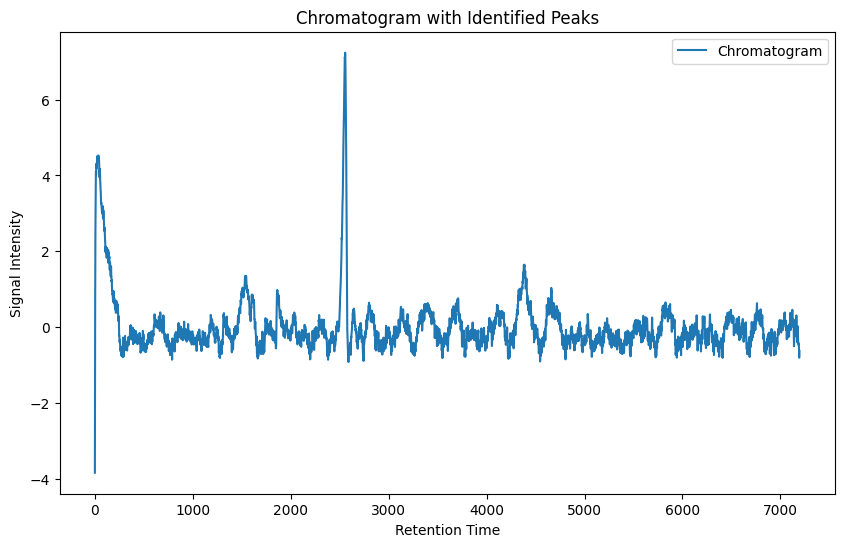

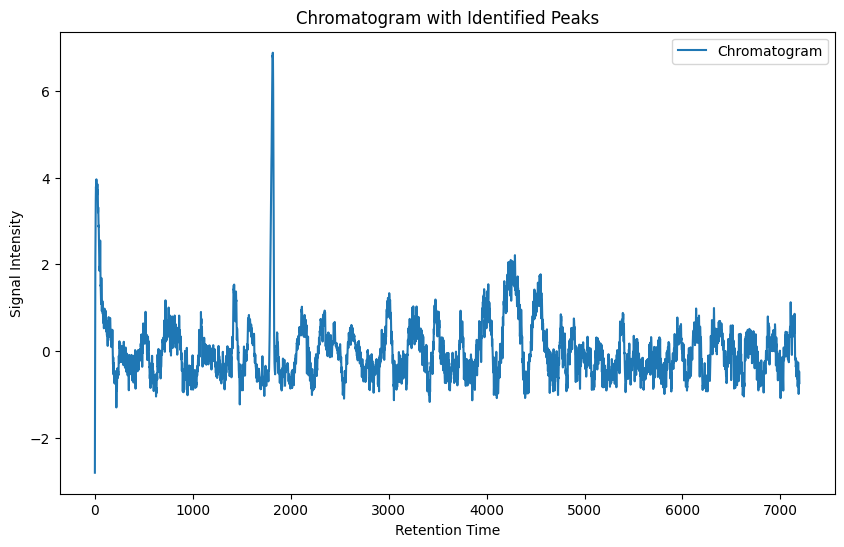

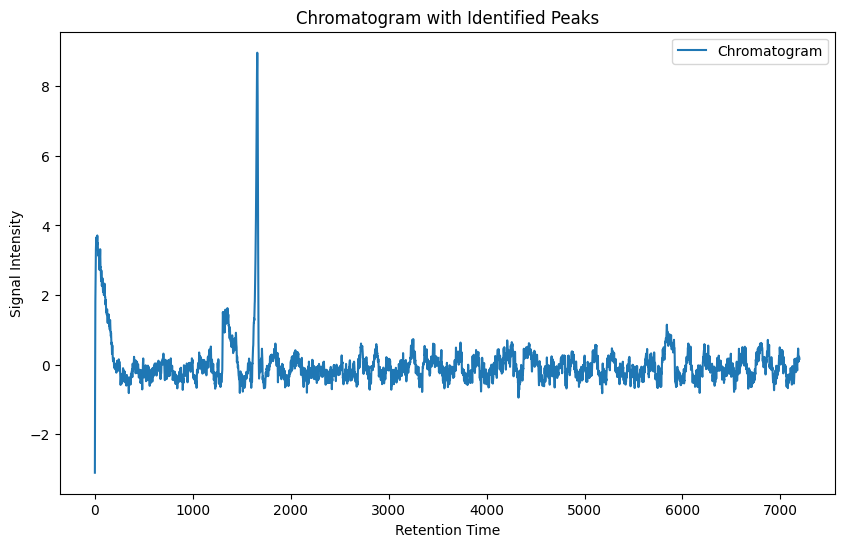

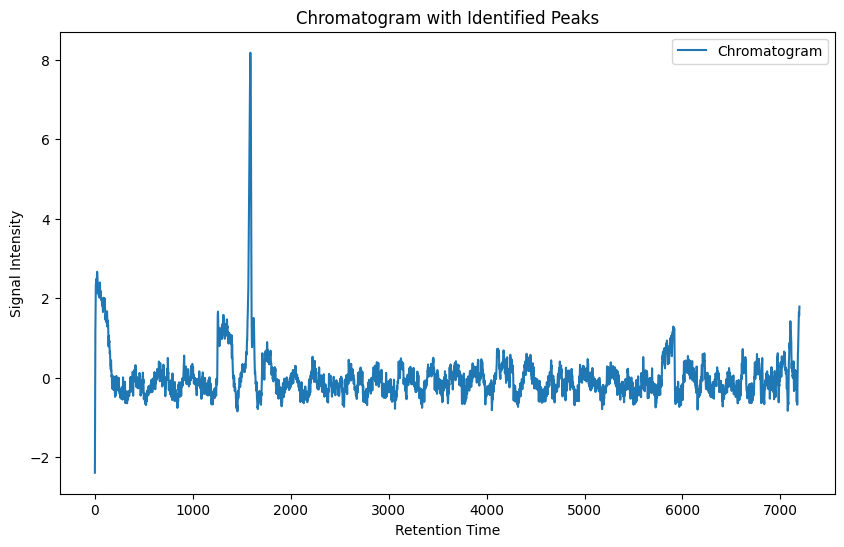

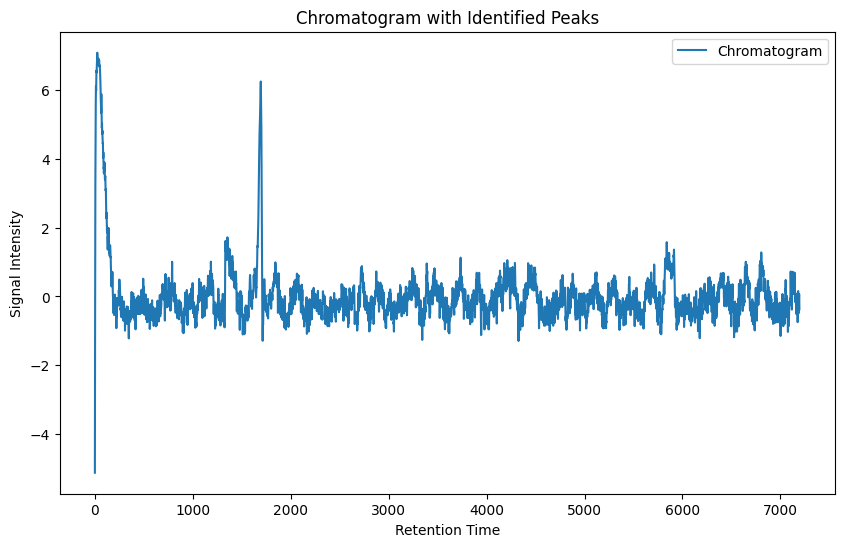

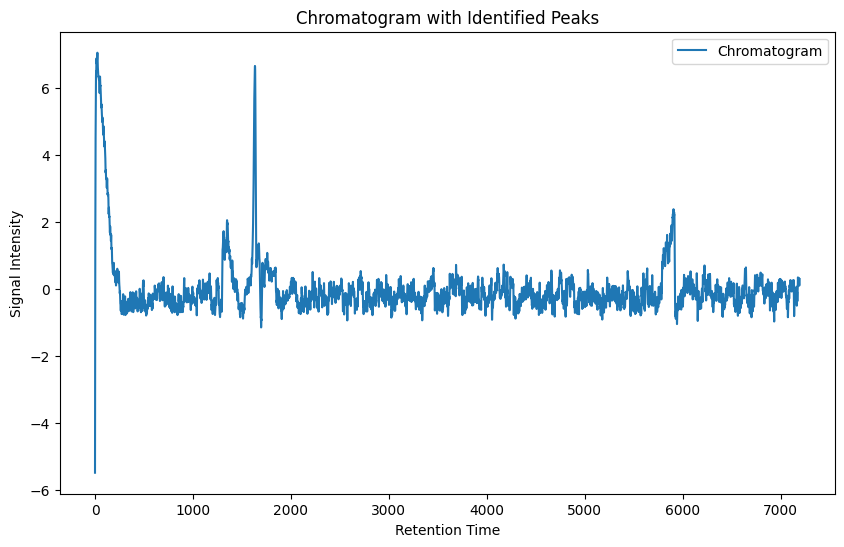

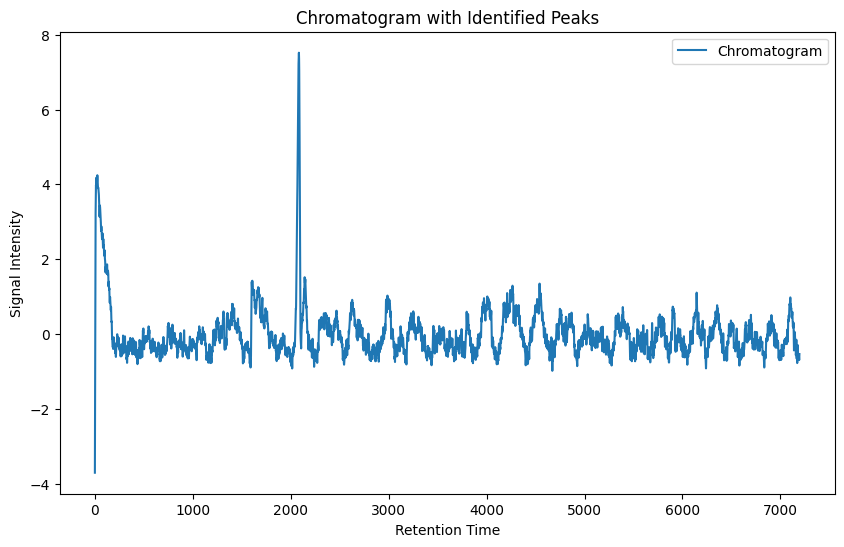

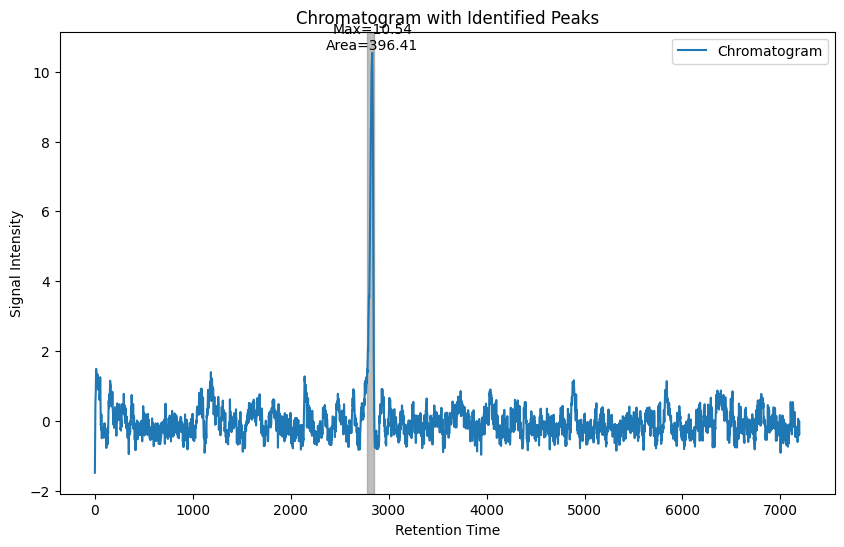

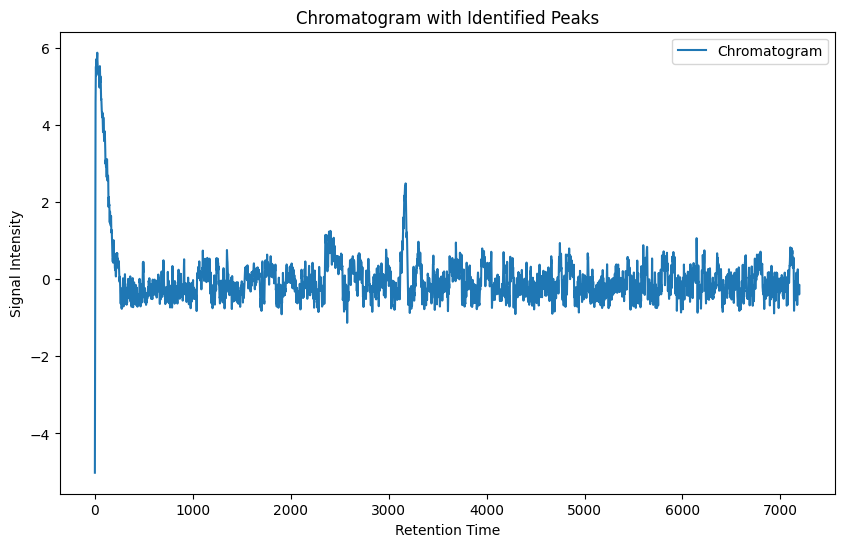

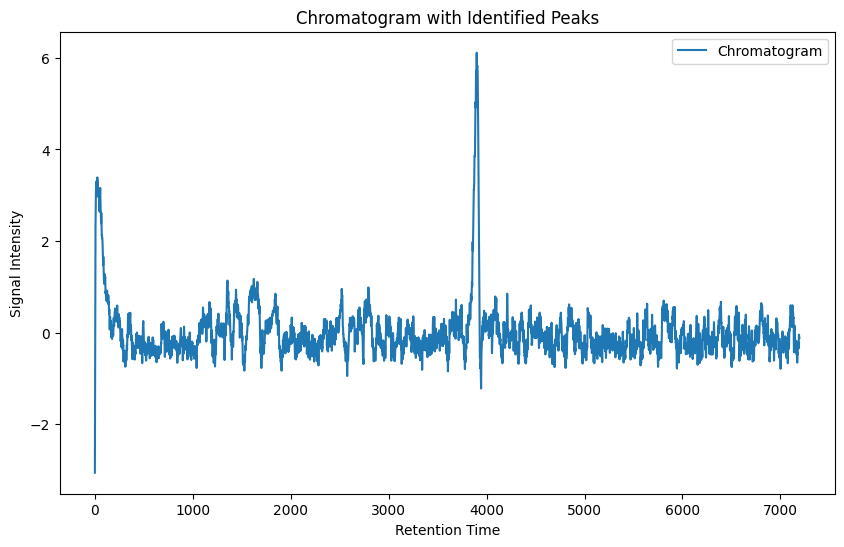

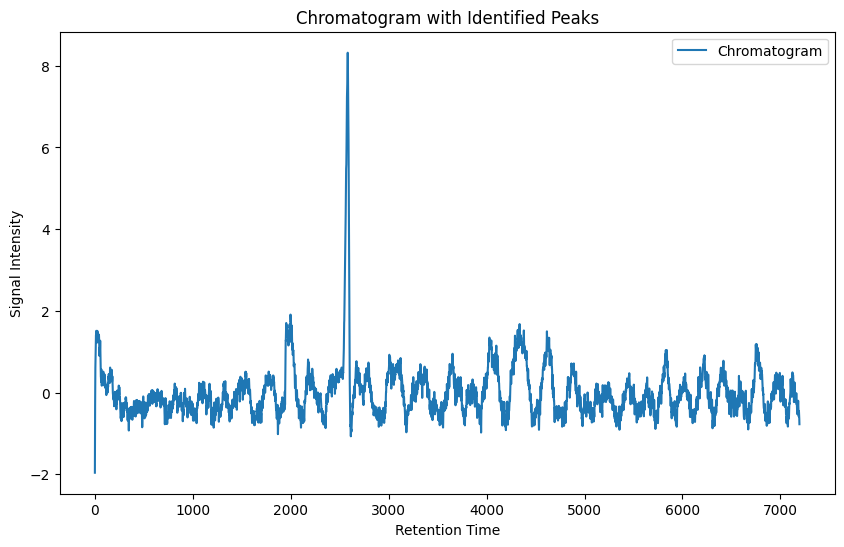

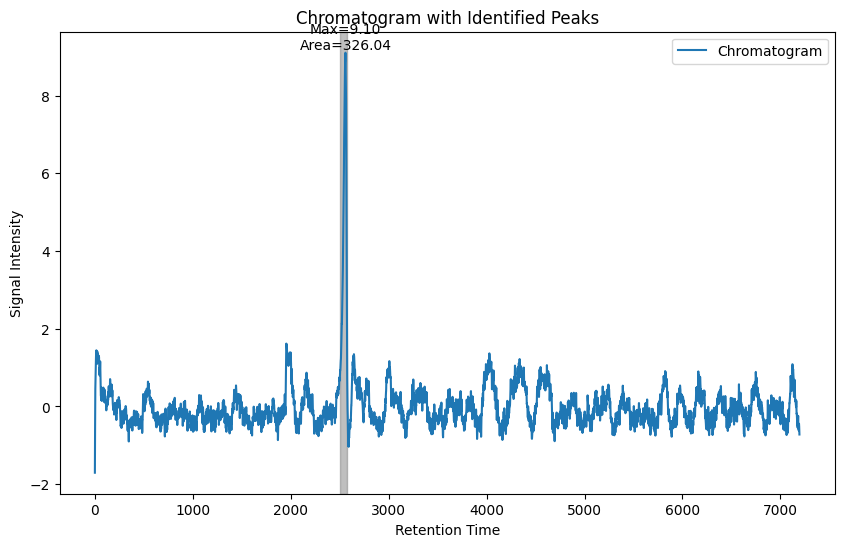

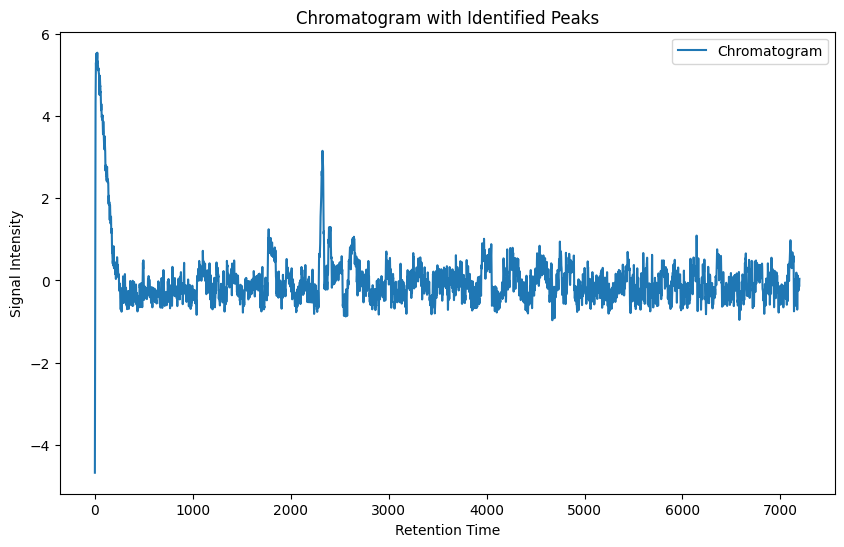

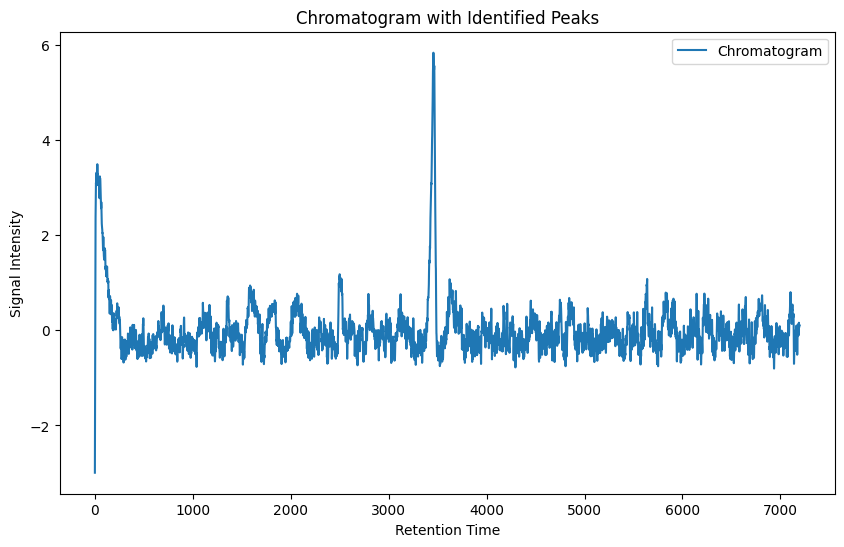

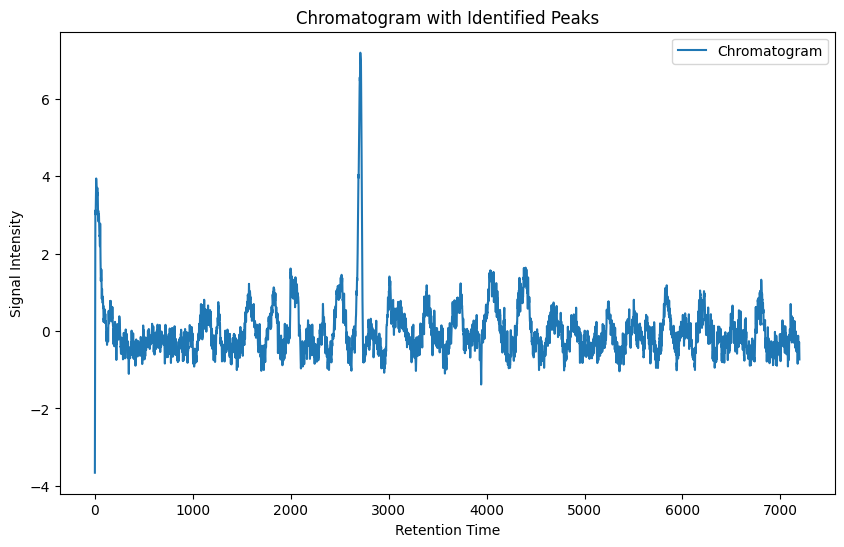

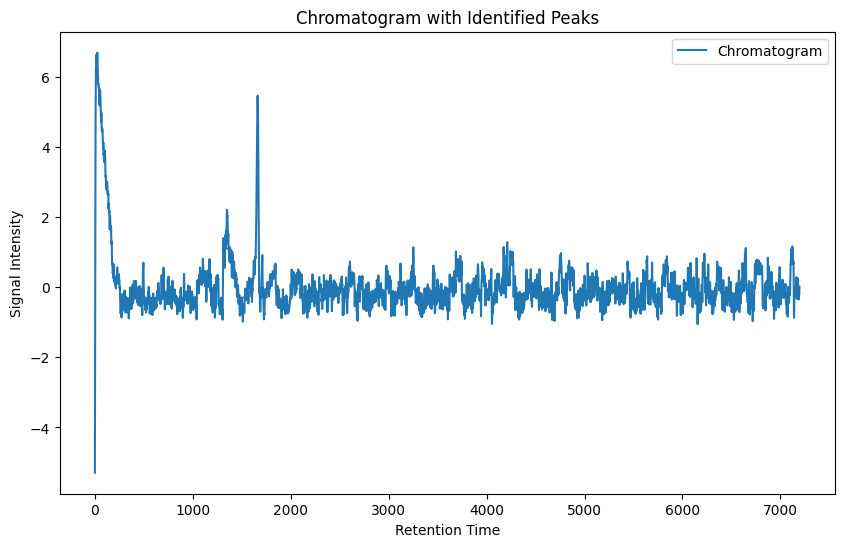

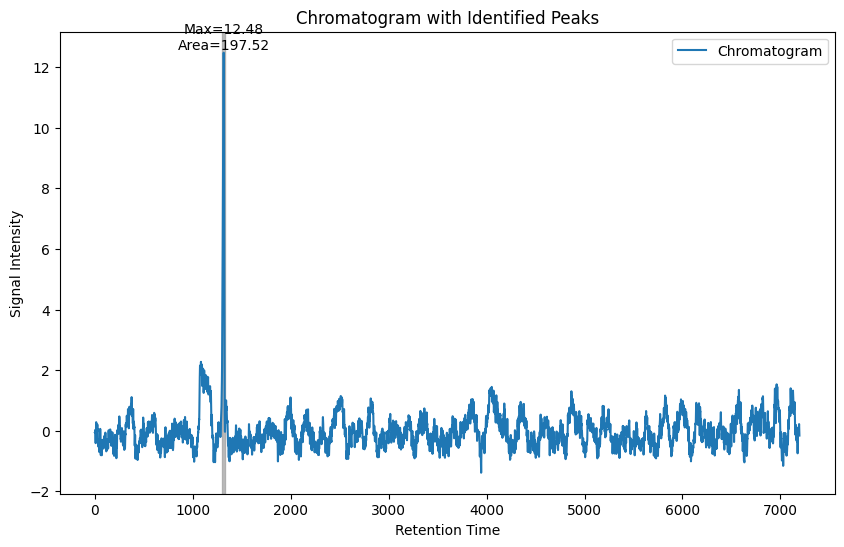

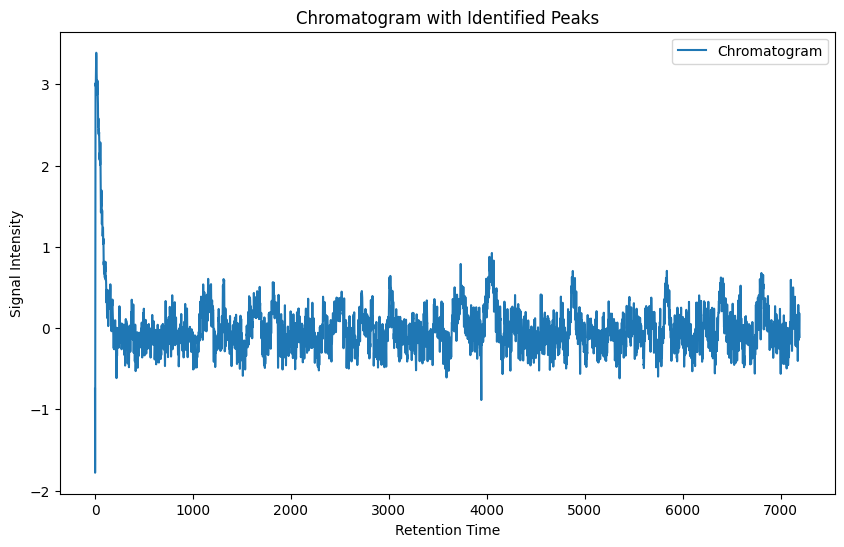

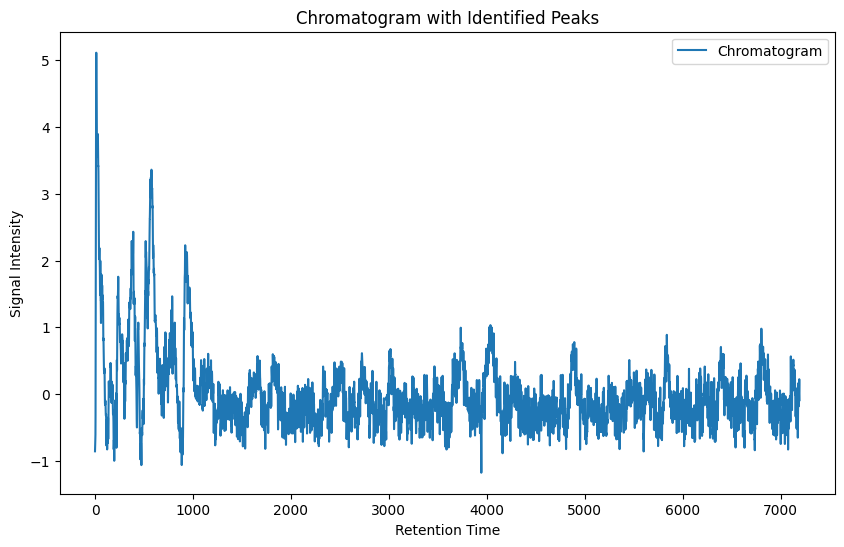

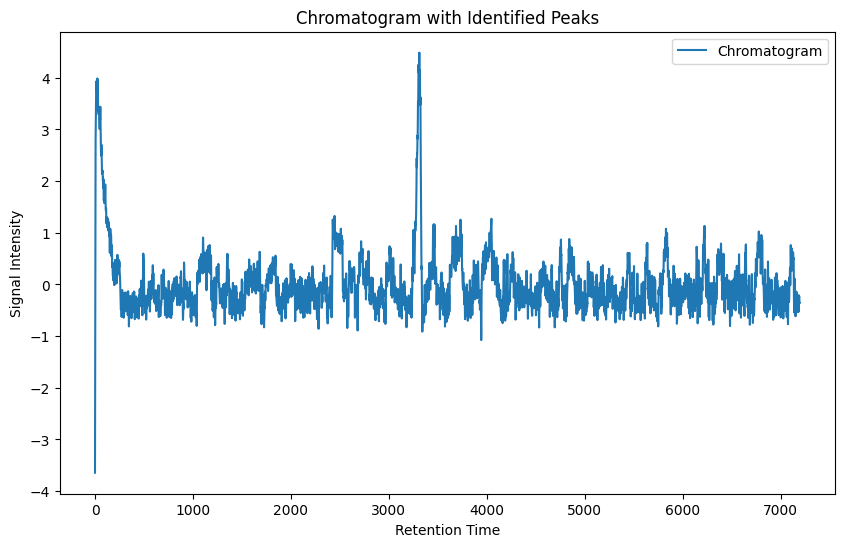

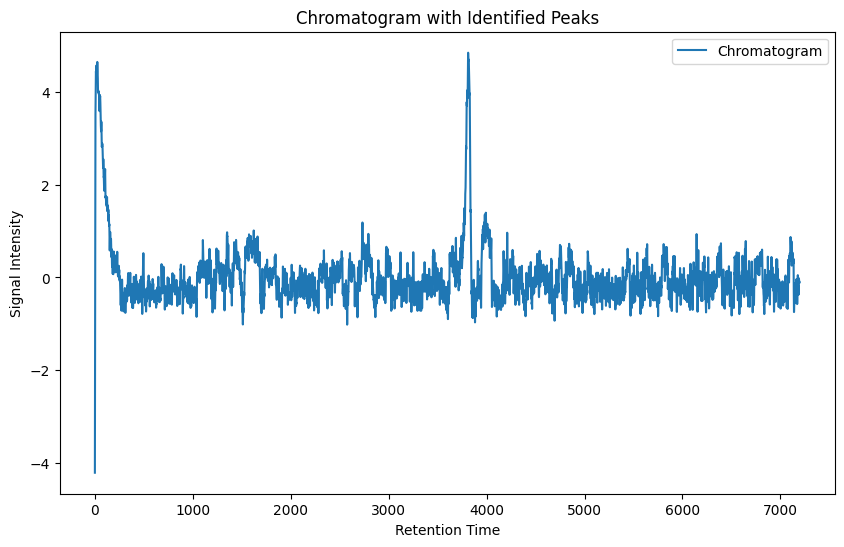

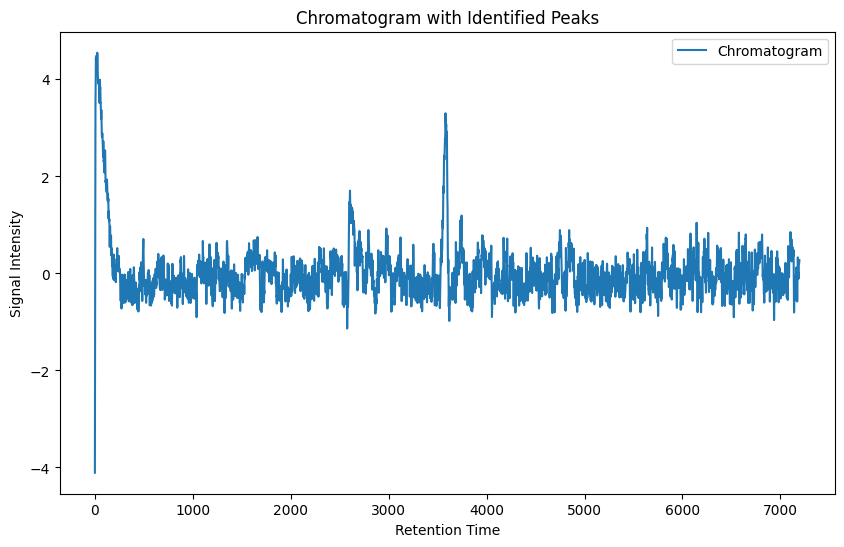

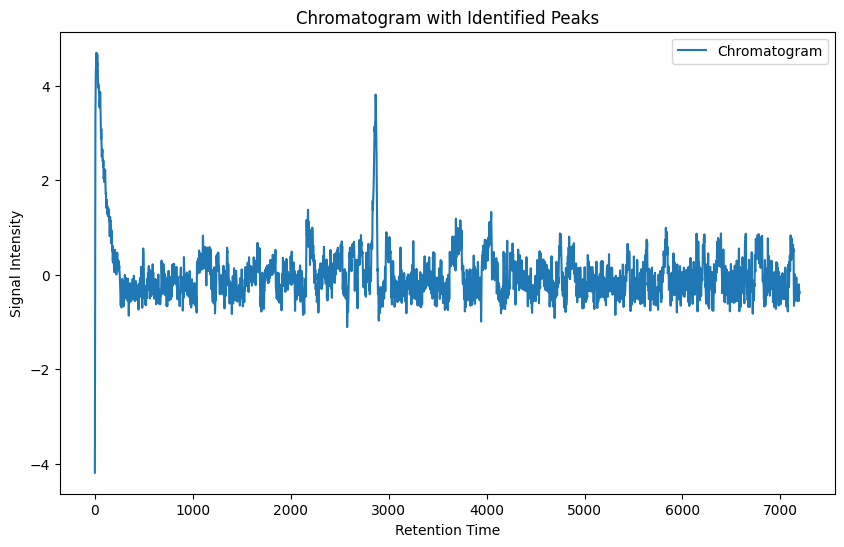

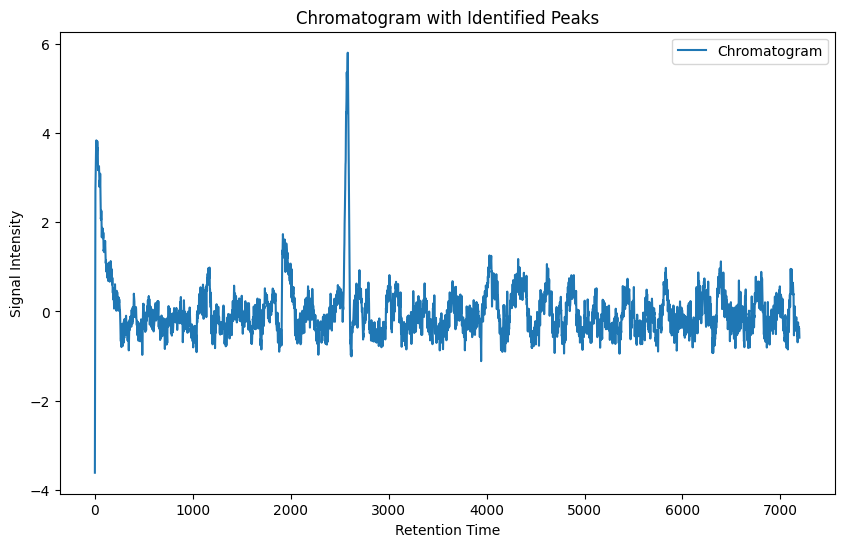

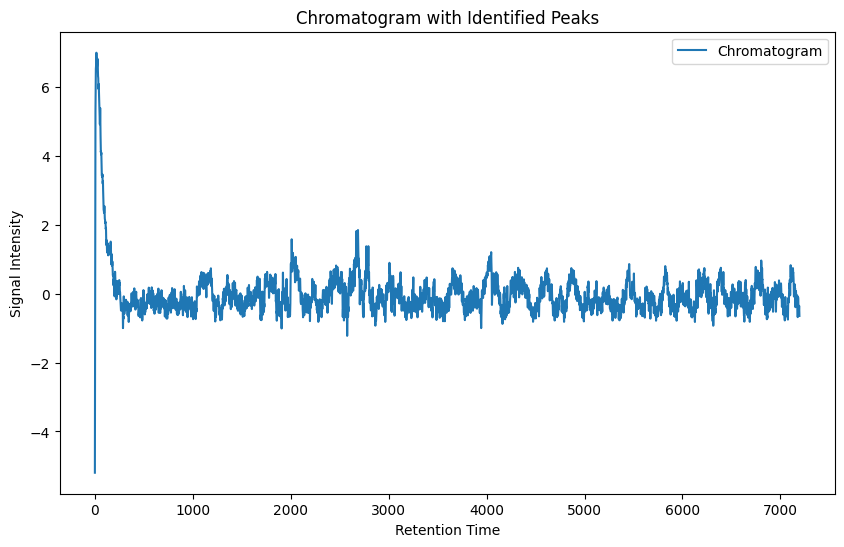

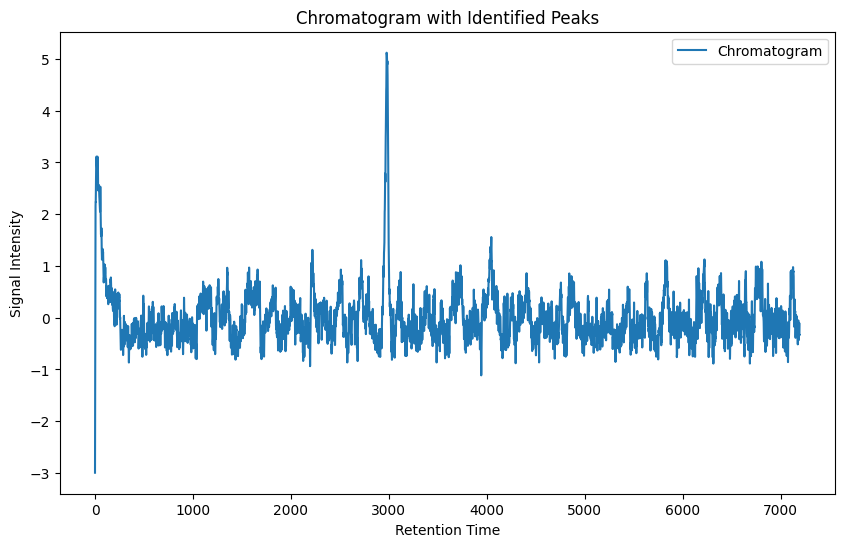

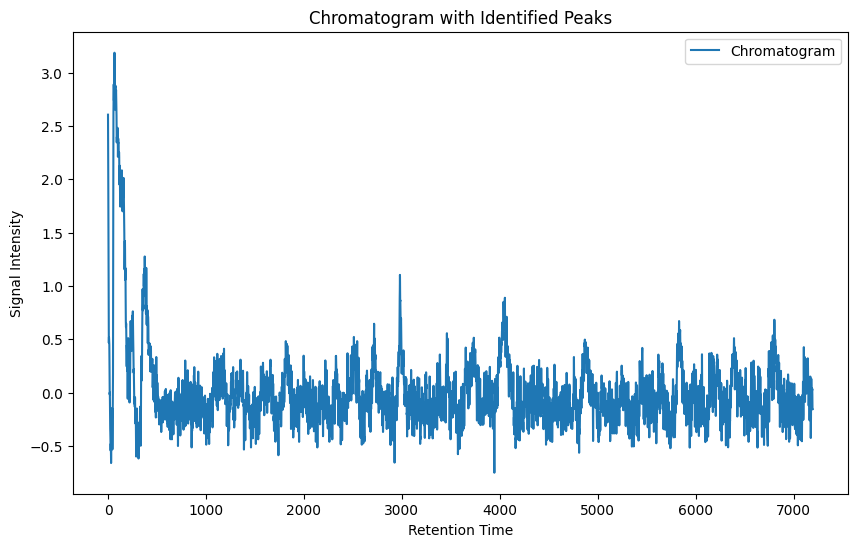

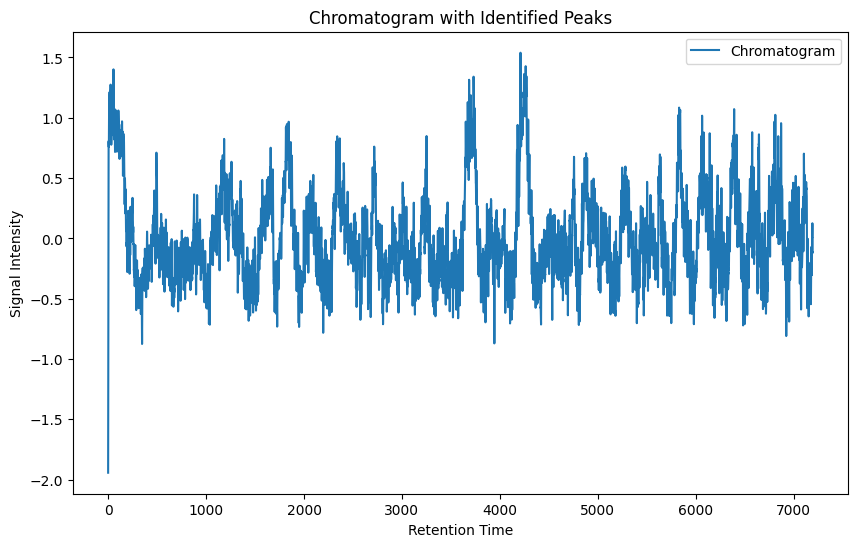

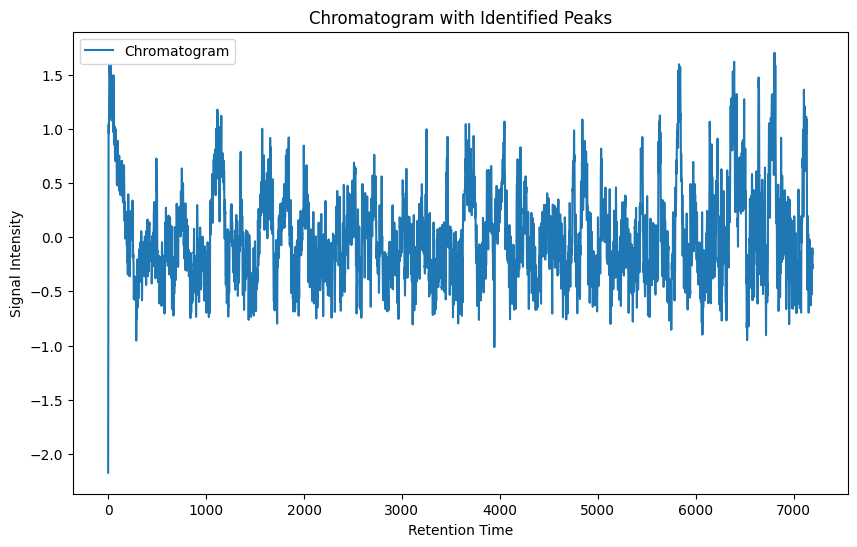

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import trapz

def analyze_chromatogram(x, y, prominence=10, width=20, rel_height=0.8):
    # Find the peaks in the chromatography data
    peaks, properties = find_peaks(y, prominence=prominence, width=width)

    # Calculate peak widths
    results_half = peak_widths(y, peaks, rel_height=rel_height)

    peak_info_list = []
    for i in range(len(peaks)):
        peak_index = peaks[i]
        left_ips = int(results_half[2][i])
        right_ips = int(results_half[3][i])
        peak_x = x[peak_index]
        peak_y = y[peak_index]
        
        # Calculate the integral of the peak (assuming evenly spaced data)
        peak_integral = trapz(y[left_ips:right_ips], x[left_ips:right_ips])

        # Store peak information in a dictionary
        peak_info = {
            "peak_position": peak_x,
            "peak_boundaries": (x[left_ips], x[right_ips]),
            "peak_maximum": peak_y,
            "peak_area": peak_integral
        }
        peak_info_list.append(peak_info)

    # Create a plot of the chromatogram with identified peaks
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Chromatogram')

    for peak_info in peak_info_list:
        peak_x = peak_info["peak_position"]
        peak_y = peak_info["peak_maximum"]
        left_boundary, right_boundary = peak_info["peak_boundaries"]
        peak_area = peak_info["peak_area"]

        # Highlight the peak region
        plt.axvspan(left_boundary, right_boundary, color='gray', alpha=0.5)

        # Label the peak maximum and area
        plt.text(peak_x, peak_y, f'Max={peak_y:.2f}\nArea={peak_area:.2f}', fontsize=10, ha='center', va='bottom')

    plt.xlabel('Retention Time')
    plt.ylabel('Signal Intensity')
    plt.legend()
    plt.title('Chromatogram with Identified Peaks')
    plt.show()

    return peak_info_list

# Example usage:
import string
for letter in string.ascii_uppercase[:8]:
    for i in range(1,12):
        x = data[f"{letter}{i}"][:, 0]
        y = data[f"{letter}{i}"][:, 2]
        peak_info = analyze_chromatogram(x, y)
